In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.autograd.functional as dp
from torch.autograd import grad
from numpy import pi

import datetime as DT
import copy

# Ejecución de un esquema de trabajo para la implementación de PINNs la solución de sistemas de distintos niveles de complejidad

El siguiente documento detalla el procedimiento explícito para el entrenamiento de redes neuronales que simulen distintas funciones dados varios parámetros iniciales, con el objetivo final de obtener una red que satisfaga las condiciones de las ecuaciones de Navier-Stokes, de manera que funcione como simulador de un flujo incompresible particular. El acercamiento que se hace sigue una convención _bottom-up_, es decir, se parte de situaciones muy simples y se procede a realizar problemas de mayor dificultad. Específicamente, sigue el siguiente esquema de trabajo:

1. Se simulan funciones escalares partiendo de la función explícita que se va a simular.
2. Se simulan funciones escalares a partir de ecuaciones diferenciales de 1er orden.
3. Se simulan funciones escalares a partir de ecuaciones diferenciales de 2do orden. ** Buscar algo más complicado acá **
4. Se simulan campos escalares y vectoriales a partir de la función explícita.
5. Se simulan campos vectoriales a partir de ecuaciones diferenciales.
7. Se simulan casos particulares de flujos incompresibles (ecuación de Navier-Stokes con simplificaciones).
8. Se simula un flujo que siga las ecuaciones de Navier-Stokes sin simplificaciones: el _lid-driven cavity flow_

Para cada problema se realiza una solución en dos bloques. Un bloque para el planteamiento del problema, incluyendo la declaración de las ecuaciones del problema y la función de error correspondiente, además de la arquitectura de la red que se utilizará. Cada grupo de dos bloques es completamente independiente de los demás, siendo posible correrlos en un archivo independiente.

# Funciones misceláneas

Se plantean las siguientes funciones auxiliares para facilitar la implementación de las redes y visualización de resultados obtenidos. Ninguna de ellas es fundamental en la solución de ninguno de los problemas.

In [2]:
# Se implementan instancias particulares de funciones de pytorch para simplificar el trabajo más adelante. Se implementan otras funciones útiles

# Crear una función para modificar las funciones para graficar

def tensor(x,requires_grad=True) -> torch.Tensor:
    """ Genera un tensor de numpy para usarlo en una PINN. Tiene la opción de gradiente activa por defecto.
        
        Keyword arguments:
        x -- valor o conjunto de valores para convertir en tensor
        requires_grad -- valor que indica si requiere calcularse el gradiente del vector. Por defecto True.
        
        Returns
        Tensor de pytorch con los valores de x
    """
    if not 'device' in globals(): device='cpu'
    return torch.tensor(x,requires_grad=requires_grad).to(device)

def detach(x:torch.Tensor) -> np.ndarray :
    """ Genera el detach de un tensor de pytorch para poder graficarlo con matplotlib
        
        Keyword arguments:
        x -- tensor al cual realizarle detach
        
        Returns
        Un vector de numpy equivalente
    """
    return x.detach().numpy()

def linspace(inf_lim,sup_lim,N=100,reshape=True,requires_grad=True):
    """ Genera un linspace de pytorch entre inf_lim y sup_lim con N puntos. Por defecto se realiza un redimensionamiento para obtener una matriz de una columna.
        
        Keyword arguments:
        inf_lim -- límite inferior del linspace
        sup_lim -- límte superior del linspace
        N -- número de puntos. Por defecto 100
        reshape -- True para realizar el redimensionamiento, False para omitirlo. Por defecto True
    """
    if not 'device' in globals(): device='cpu'
    return torch.linspace(inf_lim,sup_lim,N,requires_grad=requires_grad).reshape(N,1).to(device) if reshape else torch.linspace(inf_lim,sup_lim,N,requires_grad=requires_grad).to(device)

In [3]:
def plot2D(f,rango:tuple = ((0,1),(0,1)), N_x:int = 100, N_y:int = None, N_salidas:int = 1, figsize:tuple = (7,14), plot_cut:tuple = None, axes:tuple = None) -> None: # Genera una gráfica 2D de la función f
    # plot_cut = tuple['axis',cuts]: 'axis' = 'x' or 'y', cut:list[float]
    """ Genera un gráfico 2D (como mapa de calor) de una función con entradas de dos coordenadas, sea un campo escalar f: R2 --> R, ó un campo vectorial f: R2 --> R2. Para campos escalares se grafica la
        salida como intensidad en un mapa de calor. Para funciones vectoriales se grafica la norma como un mapa de calor y las direcciones con flechas. Permite realizar 'cortes' 1D a lo largo del espacio
        bidimensional, es decir, tomar una curva unidimensional en el espacio 2D y realizar la gráfica de la función a lo largo de dicha curva. La curva se puede definir como una función de python que
        represente y(x) ó x(y). También se reciben floats para cortes verticales/horizonales. Hay soporte para múltiples cortes siempre que todos se definan para una sóla coordenada, x ó y. Las funciones
        deben estar definidas para ser compatibles con tensores de pytorch.
        
        Keyword arguments:
        f -- la función que se graficará. type(f) = function
        rango -- el espacio en R2 en el que se graficará la función, dado como una tupla ((límite_inferior_x,límite_superior_x),(límite_inferior_x,límite_superior_x))
        N_x -- resolución en x de la gráfica resultante
        N_y -- resolución en y de la gráfica resultante. Pasar None indica que se utilice la misma resolución de x 
        N_salida -- un entero 1 ó 2, que representa el número de salidas de la función
        figsize -- tamaño de la figura
        plot_cut -- tupla que contiene: un string que indica cuál variable representa la función deseada, y una tupla de funciones/floats. e.g. ('y',(torch.sqrt,3.3,torch.abs)). None si no se desea hacer
            cortes
        axes -- tupla de instancias de matplotlib.Axes.axes sobre las cuales se desee realizar las gráficas. None si se desea crear una nueva figura.
        
        Returns:
        None
    """
    
    (inf_x,sup_x),(inf_y,sup_y) = rango
    if not N_y: N_y = N_x
    if not 'device' in globals(): device='cpu' # Pone los tensores en el dispositivo escogido
    
    # Genera los axes
    if axes is None:
        fig = plt.figure(figsize=figsize)
        if plot_cut is not None:
            gs = fig.add_gridspec(2, hspace=0)
            heatmap,cutplot = gs.subplots(sharex=True, sharey=False)
        else:
            fig,heatmap = plt.subplots()
    else:
        if plot_cut is not None:
            heatmap,cutplot = axes
        else:
            heatmap = axes[0]
    
   
    # Se genera el sampleo de x,y. Se genera una matriz donde se van a almacenar los valores del mapa de calor 
    x,y = torch.linspace(inf_x,sup_x,N_x).to(device),torch.linspace(inf_y,sup_y,N_y).to(device)
    resultado = np.zeros((len(x),len(y)))
    
    # Se llena la matriz
    if N_salidas==1: # Si la función es un campo escalar (N_salidas=1) se llena la matriz con las salidas de la función
        for i in range(len(y)):
            for j in range(len(x)):
                z = f(torch.tensor([x[j],y[i]]).to(device))
                resultado[i,j] = z
    
    elif N_salidas==2:  # Si la función es un campo vectorial (N_salidas=2) se llena la matriz con las salidas de la función
        res_x = (rango[0][1] - rango[0][0])/N_x
        res_y = (rango[1][1] - rango[1][0])/N_y
        for i in range(len(y)):
            for j in range(len(x)):
                z = f(torch.tensor([x[j],y[i]]).to(device)) # Guardar z en una lista y usarla para generar el diagrama de flechas
                norm = torch.sqrt(torch.sum(torch.pow(z,2)))
                resultado[i,j] = norm
                
                if i%int(N_x/10 - 1)==0 and j%int(N_y/10 - 1)==0:
                    L0 = detach(norm)
#                     x_length = max(min(detach(z[0]),1.,key=abs),0.2,key=abs)/detach(norm)*res_x*5 #*res_x*5
#                     y_length = max(min(detach(z[1]),1.,key=abs),0.2,key=abs)/detach(norm)*res_y*5
#                     x_length = detach(z[0])/detach(norm)*res_x*5
#                     y_length = detach(z[1])/detach(norm)*res_y*5
                    x_length = detach(z[0])*(1.2*np.tanh(0.5*L0)+0.3)/L0*res_x*5
                    y_length = detach(z[1])*(1.2*np.tanh(0.5*L0)+0.3)/L0*res_y*5
                    heatmap.arrow(detach(x[j]),detach(y[i]),x_length,y_length,head_width=0.03,facecolor='black')
                
     # Genera el mapa de calor
    heatmap.imshow(resultado,origin='lower',extent=[inf_x,sup_x,inf_y,sup_y])
    heatmap.set_xlim(inf_x,sup_x)
    heatmap.set_ylim(inf_y,sup_y)
    heatmap.label_outer()
    
    # Genera el gráfico de cortes, y coloca las curvas en el mapa de calor
    if plot_cut is not None:
        for cut in plot_cut[1]:
            N = N_x if plot_cut[0] == 'y' else N_y
            abscissa = torch.linspace(inf_x,sup_x,N).reshape(N,1)
            if type(cut) == float:
                ordinate = cut*torch.ones(N).reshape(N,1)
                label = plot_cut[0]+' = {:.1f}'.format(cut)
            elif callable(cut):
                ordinate = cut(abscissa)
                label = plot_cut[0]+' = '+cut.__name__+ ( '(x)' if plot_cut[0] == 'y' else '(y)')
            x,y = (abscissa,ordinate) if plot_cut[0] == 'y' else (ordinate,abscissa) 
            xy = torch.hstack((x,y))
            z = f(xy) if N_salidas == 1 else torch.sqrt(torch.sum( torch.pow(f(xy),2), axis=1 ))
            cutplot.plot(detach(x),detach(z),label=label)
            heatmap.plot(x,y,color='red')
        cutplot.label_outer()
        cutplot.yaxis.get_major_ticks()[-1].label1.set_visible(False)
        cutplot.legend()
        heatmap.yaxis.get_major_ticks()[0].label1.set_visible(False)
        
    heatmap.set_aspect('auto')
    

def plot2D_error(f,rango:tuple = ((0,1),(0,1)), N_x:int = 100, N_y:int = None, figsize:tuple = (7,14), plot_cut:tuple = None, axes:tuple = None) -> None: # Genera una gráfica 2D del error de la función f
    # plot_cut = tuple['axis',cuts]: 'axis' = 'x' or 'y', cut:list[float]
    """ Genera un gráfico 2D (como mapa de calor) del error de una función con entradas de dos coordenadas, sea un campo escalar f: R2 --> R, ó un campo vectorial f: R2 --> R2. Permite realizar 'cortes'
        1D a lo largo del espacio bidimensional, es decir, tomar una curva unidimensional en el espacio 2D y realizar la gráfica de la función a lo largo de dicha curva. La curva se puede definir como
        una función de python que represente y(x) ó x(y). También se reciben floats para cortes verticales/horizonales. Hay soporte para múltiples cortes siempre que todos se definan para una sola
        coordenada, x ó y. Las funciones deben estar definidas para ser compatibles con tensores de pytorch.
        
        Keyword arguments:
        f -- la función cuyo error se graficará. type(f) = function
        rango -- el espacio en R2 en el que se graficará la función, dado como una tupla ((límite_inferior_x,límite_superior_x),(límite_inferior_x,límite_superior_x))
        N_x -- resolución en x de la gráfica resultante
        N_y -- resolución en y de la gráfica resultante. Pasar None indica que se utilice la misma resolución de x
        figsize -- tamaño de la figura
        plot_cut -- tupla que contiene: un string que indica cuál variable representa la función deseada, y una tupla de funciones/floats. e.g. ('y',(torch.sqrt,3.3,torch.abs)). None si no se desea hacer
            cortes
        axes -- tupla de instancias de matplotlib.Axes.axes sobre las cuales se desee realizar las gráficas. None si se desea crear una nueva figura.
        
        Returns:
        None
    """
    
    (inf_x,sup_x),(inf_y,sup_y) = rango
    if not N_y: N_y = N_x
    if not 'device' in globals(): device='cpu' # Pone los tensores en el dispositivo escogido
    
    # Genera los axes
    if axes is None:
        fig = plt.figure(figsize=figsize)
        if plot_cut is not None:
            gs = fig.add_gridspec(2, hspace=0)
            heatmap,cutplot = gs.subplots(sharex=True, sharey=False)
        else:
            fig,heatmap = plt.subplots()
    else:
        if plot_cut is not None:
            heatmap,cutplot = axes
        else:
            heatmap = axes[0]
    
   
    # Se genera el sampleo de x,y. Se genera una matriz donde se van a almacenar los valores del mapa de calor 
    x,y = torch.linspace(inf_x,sup_x,N_x).to(device),torch.linspace(inf_y,sup_y,N_y).to(device)
    resultado = np.zeros((len(x),len(y)))
    
    # Se llena la matriz
    for i in range(len(y)):
        for j in range(len(x)):
            z = error(tensor([x[j],y[i]]).reshape(1,2).to(device))
            resultado[i,j] = z

     # Genera el mapa de calor
    im = heatmap.imshow(resultado,origin='lower',extent=[inf_x,sup_x,inf_y,sup_y])
    heatmap.figure.colorbar(im)
    heatmap.set_xlim(inf_x,sup_x)
    heatmap.set_ylim(inf_y,sup_y)
    heatmap.label_outer()
    
    # Genera el gráfico de cortes, y coloca las curvas en el mapa de calor
    if plot_cut is not None:
        for cut in plot_cut[1]:
            N = N_x if plot_cut[0] == 'y' else N_y
            abscissa = torch.linspace(inf_x,sup_x,N).reshape(N,1)
            if type(cut) == float:
                ordinate = cut*torch.ones(N).reshape(N,1)
                label = plot_cut[0]+' = {:.1f}'.format(cut)
            elif callable(cut):
                ordinate = cut(abscissa)
                label = plot_cut[0]+' = '+cut.__name__+ ( '(x)' if plot_cut[0] == 'y' else '(y)')
            x,y = (abscissa,ordinate) if plot_cut[0] == 'y' else (ordinate,abscissa) 
            xy = torch.hstack((x,y))
            z = []
            for xy_i in xy:
                z.append(error(xy))
            cutplot.plot(detach(x),z,label=label)
            heatmap.plot(x,y,color='red')
        cutplot.label_outer()
        cutplot.yaxis.get_major_ticks()[-1].label1.set_visible(False)
        cutplot.legend()
        heatmap.yaxis.get_major_ticks()[0].label1.set_visible(False)
        
    heatmap.set_aspect('auto')

# Entrenar a partir de funciones explícitas

## Función cuadrática: $ y = x^2 $

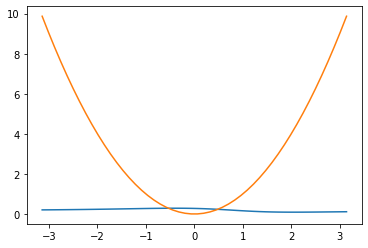

In [4]:
def f(x):
    return torch.pow(x,2) # Siempre usar pow, nunca a**n

def error(x):
    return torch.abs(model(x) - f(x))

def residuales(X):
    res = 0
    for x in X:
        res += error(x)
    return res

model = torch.nn.Sequential(torch.nn.Linear(1,6), # Red neuronal, compuesta de transformaciones lineales ([1x6] y [6x1]) con una función de activación no lineal de por medio.
                           torch.nn.Tanh(),
                           torch.nn.Linear(6,1))

params_iniciales = copy.deepcopy(model.state_dict())

N_sample = 50
x0 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1) # Muestreo para graficar
y0 = model(x0)

plt.plot(detach(x0),detach(y0))
plt.plot(detach(x0),f(x0))
plt.show()

Tiempo promedio:	 0.009639606666666667
tensor([9.0933], grad_fn=<AddBackward0>) tensor([9.0995], grad_fn=<AddBackward0>)


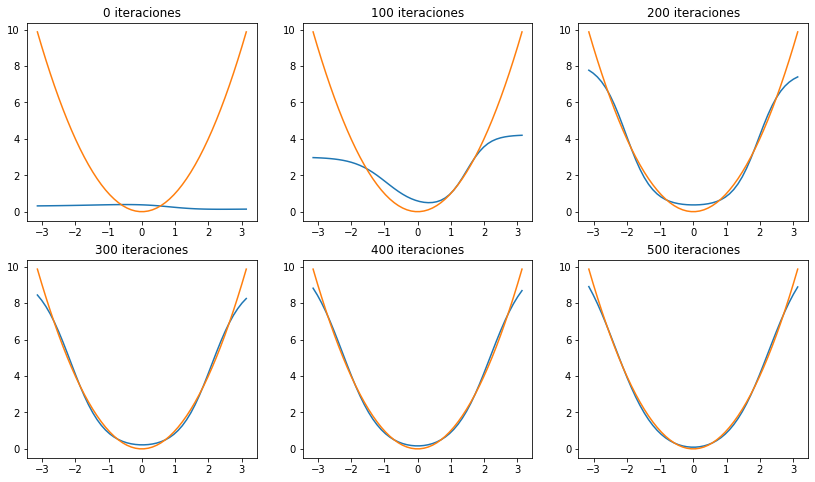

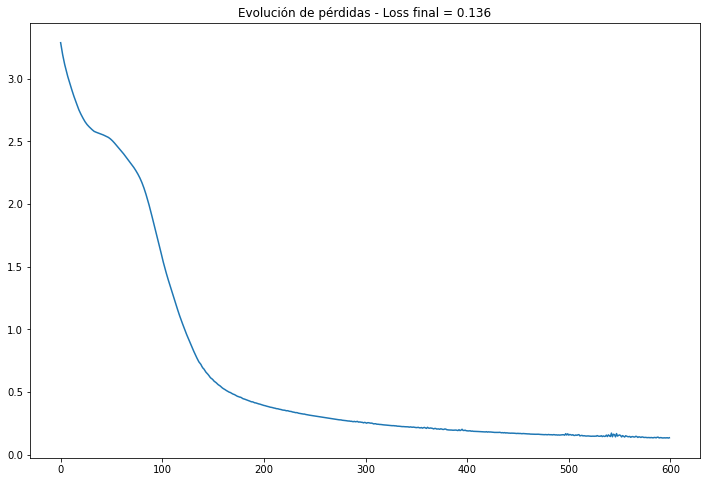

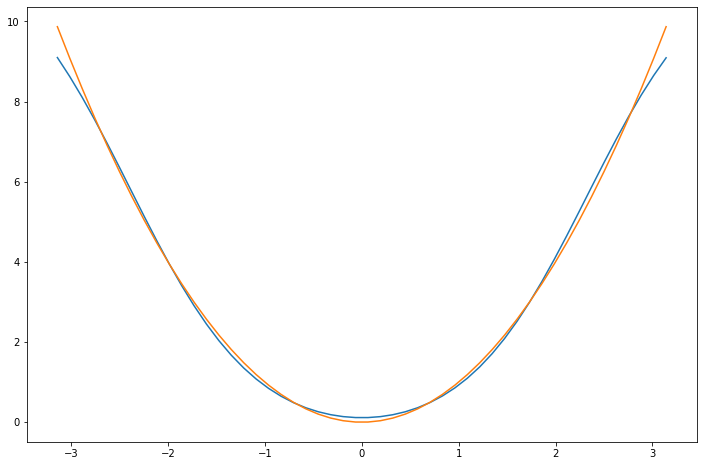

In [5]:
model.load_state_dict(params_iniciales) # Se vuelven a cargar los parámetros iniciales, de manera que cuando se realicen cambios, se pueda ver su efecto en la red inicial aleatoria, y no sobre la red ya entrenada

# Se genera el dominio. En este archivo se usa linspaces simples, pero lo recomendable es seleccionar la ubicación más conveniente para los puntos y usar distribuciones de probabilidad.
N_sample = 50 # Número de muestras para el entrenamiento
x1 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1) # Muestreo para el entrenamiento
x = x1

optimizer = torch.optim.Adam(model.parameters(),lr=0.02) #0.04

n_epochs = 600 #300
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(14,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/6) == 0:
        y = model(x1)
        plt.subplot(2,3,int(i/int(n_epochs/6)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),f(x1))

# plt.savefig('its_cuadratica_1.svg',bbox_inches='tight')

t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]/N_sample))
plt.plot(losses/N_sample)
# plt.savefig('losses_cuadratica_1.svg',bbox_inches='tight')

y = model(x1)
plt.figure(figsize=(12,8))
plt.plot(detach(x1),detach(y))
plt.plot(detach(x1),f(x1))
# plt.savefig('resultado_cuadratica_1.svg',bbox_inches='tight')

print(model(tensor([np.pi])),model(tensor([-np.pi])))

## Senosoidal: $ y = sin(x + \pi/4)$

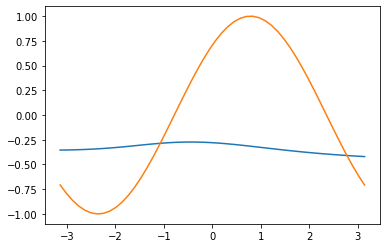

In [6]:
# Plantear alpha como variable global en cada problema en el segundo bloque.

def f(x): # Función que se busca aproximar
    return torch.sin(x+pi/4)

def error(x): # Función de error para un ajuste a una función conocida.
    return torch.abs(model(x) - f(x))

def residuales(X): # Función que calcula el error total para un conjunto de puntos
    res = 0
    for x in X:
        res += error(x)
    return res

# Es conveniente que el número de capas corresponda con el número de puntos de inflexión de la función
# tanh sirve mejor para dar curvas suaves, ReLu sirve más para cambios rápidos

model = torch.nn.Sequential(torch.nn.Linear(1,3),
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,1) )

params_iniciales = copy.deepcopy(model.state_dict()) # Se guardan los parámetros (pesos) iniciales de la red

N_sample = 50
x0 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1)
y0 = model(x0)

plt.plot(detach(x0),detach(y0))
plt.plot(detach(x0),f(x0))
plt.show()

Tiempo promedio:	 0.01752626666666667


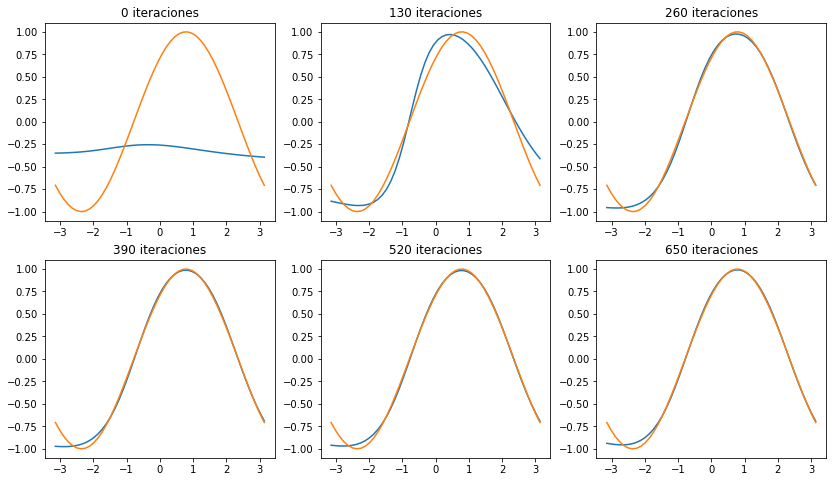

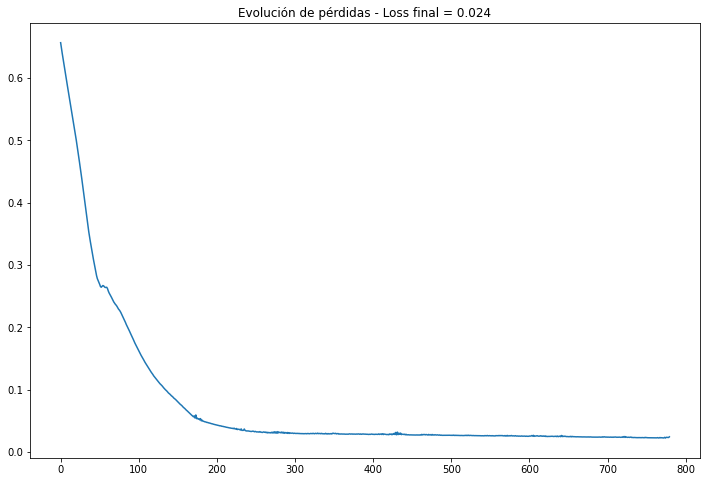

In [7]:
model.load_state_dict(params_iniciales)

N_sample = 50

x1 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1)
x = x1

optimizer = torch.optim.Adam(model.parameters(),lr=0.004) # Mi experiencia con Adam ha sido *mucho* mejor que con SGD. Aún no he explorado otros optimizadores

n_epochs = 780
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(14,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/6) == 0:
        y = model(x1)
        plt.subplot(2,3,int(i/int(n_epochs/6)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),f(x1))

# plt.savefig('its_senosoidal_1.0.svg',bbox_inches='tight')

t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]/N_sample))
plt.plot(losses/N_sample)
# plt.savefig('losses_senosoidal_1.0.svg',bbox_inches='tight')


# Es importante para las curvas considerar la "palanca" en la curva. El peso del sampleo entre dos puntos críticos o una frontera y un punto crítico: tener una gran cantidad de puntos
# en dicho espacio es importante para que la red obedezca el cambio en curvatura. De lo contrario es posible que la red simplemente asuma el sacrificio en error por 'pereza'. Es decir,
# puede que el gradiente de error resultante no sea lo suficientemente fuerte como para generar ese cambio de curvatura.

Evidentemente hay un problema con la solución obtenida, a pesar de ya haberse estabilizado el error, aún hay una sección de la función que claramente no se acomoda correctamente al comportamiento que se quería simular. Esto se debe a un efecto de "palanca" en la curva. El peso del sampleo entre dos puntos críticos o una frontera y un punto crítico: tener una gran cantidad de puntos en dicho espacio es importante para que la red obedezca el cambio en curvatura. De lo contrario es posible que la red simplemente asuma el sacrificio en error por 'pereza'. Es decir, puede que el componente del gradiente de error asociado a esta región no sea lo suficientemente fuerte como para contrarrestar el desacomodamiento que se daría en el resto del dominio con un cambio de parámetros. En otras palabras, se forma un mínimo local del error que es demasiado profundo para escapar.

Como solución a este problema, se puede hacer un muestreo adicional en la región problemática para incrementar la incidencia de esta en el error con respecto al resto del dominio.

Tiempo promedio:	 0.01944832121212121


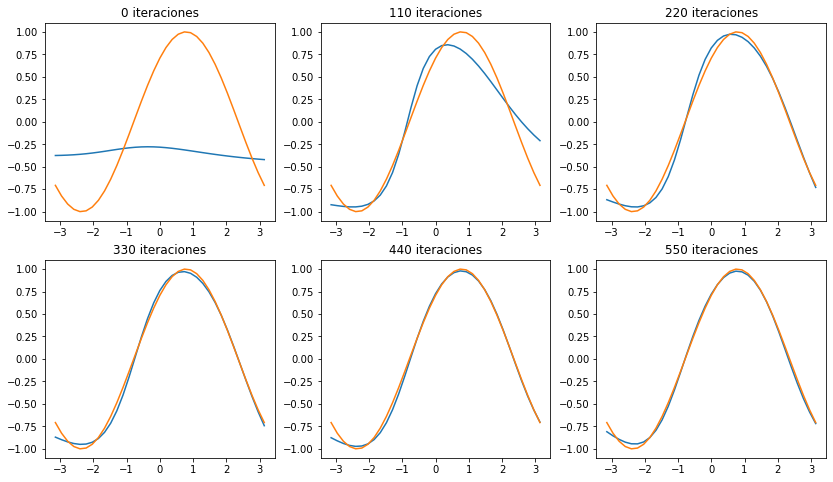

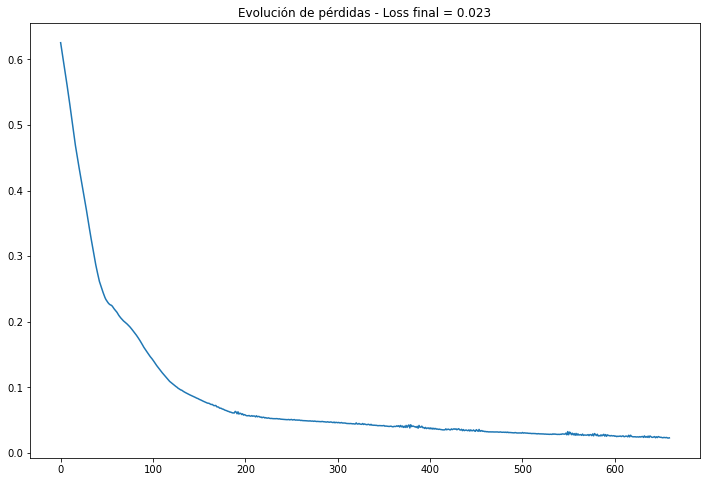

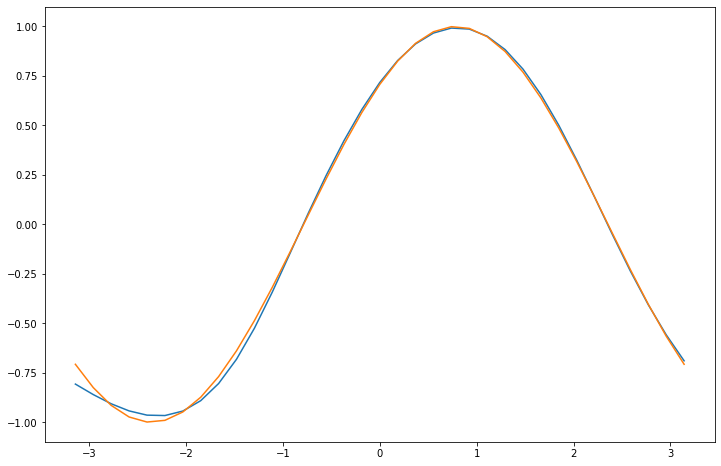

In [8]:
model.load_state_dict(params_iniciales)

N_sample = 35
N_complement = 15
N_total = N_sample + N_complement

x1 = linspace(-pi,pi,N_sample)
x2 = linspace(-3.2,-2,N_complement) # Se agrega un sampleo lineal adicional para mostrar el efecto de una selección 'inteligente' de puntos.
x = torch.vstack((x1,x2))

optimizer = torch.optim.Adam(model.parameters(),lr=0.004) # Mi experiencia con Adam ha sido *mucho* mejor que con SGD. Aún no he explorado otros optimizadores

n_epochs = 660
loss_list = []
t1 = DT.datetime.now()

# Es importante para las curvas considerar la "palanca" en la curva. El peso del sampleo entre dos puntos críticos o una frontera y un punto crítico: tener una gran cantidad de puntos
# en dicho espacio es importante para que la red obedezca el cambio en curvatura. De lo contrario es posible que la red simplemente asuma el sacrificio en error por 'pereza'. Es decir,
# puede que el gradiente de error resultante no sea lo suficientemente fuerte como para generar ese cambio de curvatura.

plt.figure(figsize=(14,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/6) == 0:
        y = model(x1)
        plt.subplot(2,3,int(i/int(n_epochs/6)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),detach(f(x1)) )

# plt.savefig('its_senosoidal_1.1.svg',bbox_inches='tight')

    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]/N_total))
plt.plot(losses/N_total)
# plt.savefig('losses_senosoidal_1.1.svg',bbox_inches='tight')

y = model(x1)
plt.figure(figsize=(12,8))
plt.plot(detach(x1),detach(y))
plt.plot(detach(x1),detach(f(x1)))
# plt.savefig('resultado_senosoidal_1.1.svg',bbox_inches='tight')

Ahora, no sólo se observa que la función fue capaz de acomodar correctamente la región problemática, también se observa una disminución en el loss con respecto al caso anterior, y en un número menor de épocas. Más aún, este caso es muy ilustrativo, puesto que se puede ver muy claramente el cambio en la evolución de pérdidas. La zona de la función de pérdidas que antes era plana ahora está inclinada, conduciendo a la red a un punto de menores pérdidas. Se nota, entonces, que la introducción del muestreo adicional en la localidad problemática ha generado una deformación en el campo escalar que es la función de error, eliminando el valle estable que da la solución no-mínima.

## Función exponencial: $ y = e^x$

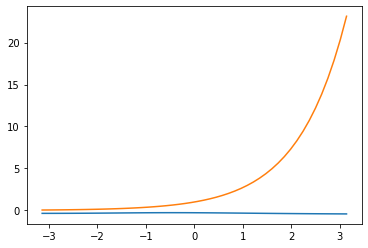

In [9]:
def f(x):
    return torch.exp(x)

def error(x):
    return torch.abs(model(x) - f(x))

def residuales(X):
    res = 0
    for x in X:
        res += error(x)
    return res

model = torch.nn.Sequential(torch.nn.Linear(1,3), # Para exponencial
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(3,1) )

params_iniciales = copy.deepcopy(model.state_dict())

N_sample = 50
x0 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1)
y = model(x0)

plt.plot(detach(x0),detach(y0))
plt.plot(detach(x0),f(x0))

Tiempo promedio:	 0.017211823333333334


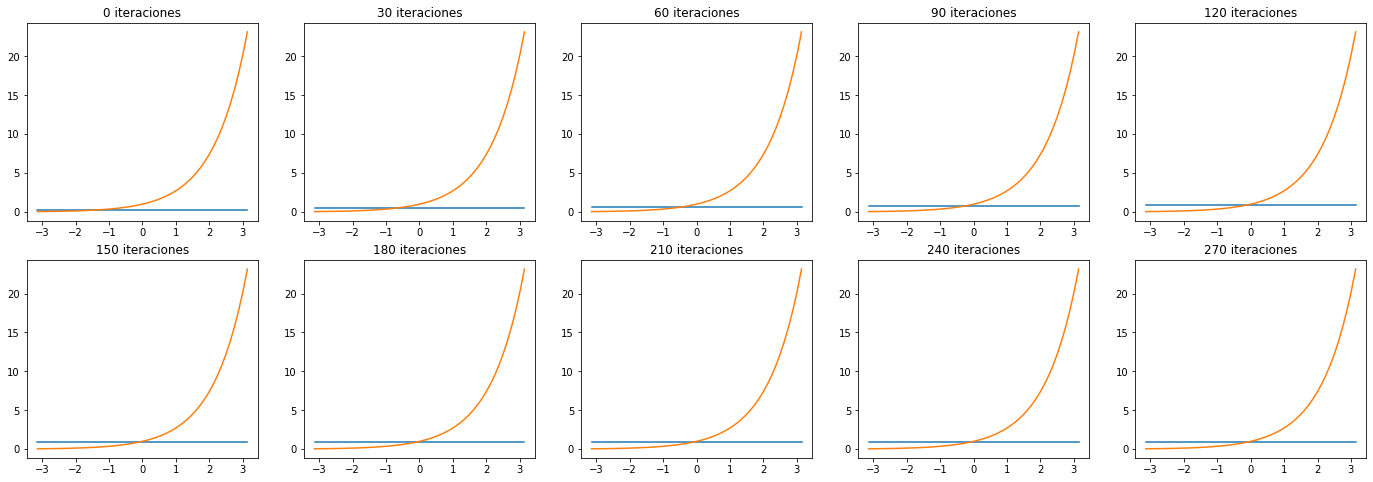

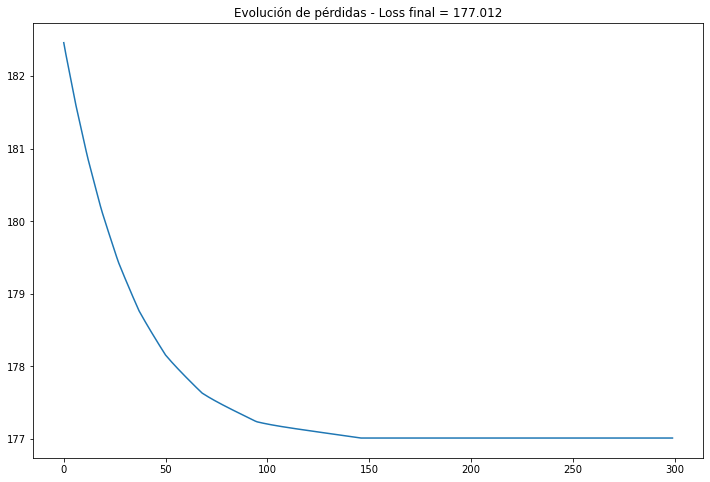

In [10]:
model.load_state_dict(params_iniciales)

N_sample = 50
x1 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1)
x = x1

optimizer = torch.optim.Adam(model.parameters(),lr=0.008)

n_epochs = 300
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/10) == 0:
        y = model(x1)
        plt.subplot(2,5,int(i/int(n_epochs/10)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),f(x1))
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]))
plt.plot(losses)

# Entrenar a partir de ecuaciones diferenciales de primer orden

## Función cuadrática:
## $\frac{df}{dx} = 2x$ ;  $f(0) = 0$

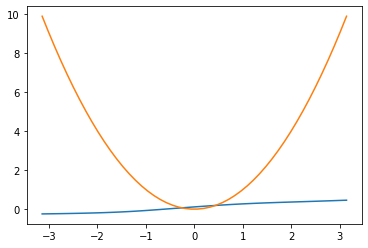

In [11]:
def jacobiano(x):
    return dp.jacobian(model,x,create_graph=True)

def f(x):
    return torch.pow(x,2)

def df(x): # Función que representa la primera derivada que se busca ajustar
    return 2*x

def error(x):# Función de error para una primera derivada conocida
    return torch.abs(jacobiano(x)-df(x))

def error_frontera(): # Función de error para un punto de valor conocido f(x), en este caso f(0) = 0
    return torch.abs(model(tensor([0.]))-f(tensor(0.)))

def residuales(X):
    global alpha # El coeficiente alpha sopesa qué tanto valor se le dará a la condición de frontera con respecto a la ecuación diferencial
    res = 0
    for x in X:
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha # Además del error dado por la derivada en cada punto sampleado, se agrega un error correspondiente a la condición de frontera
    return res

model = torch.nn.Sequential(torch.nn.Linear(1,6),
                           torch.nn.Tanh(),
                           torch.nn.Linear(6,1))

params_iniciales = copy.deepcopy(model.state_dict())

N_sample = 50
x0 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1)
y0 = model(x0)

plt.plot(detach(x0),detach(y0))
plt.plot(detach(x0),f(x0))

Tiempo promedio:	 0.025511285714285716


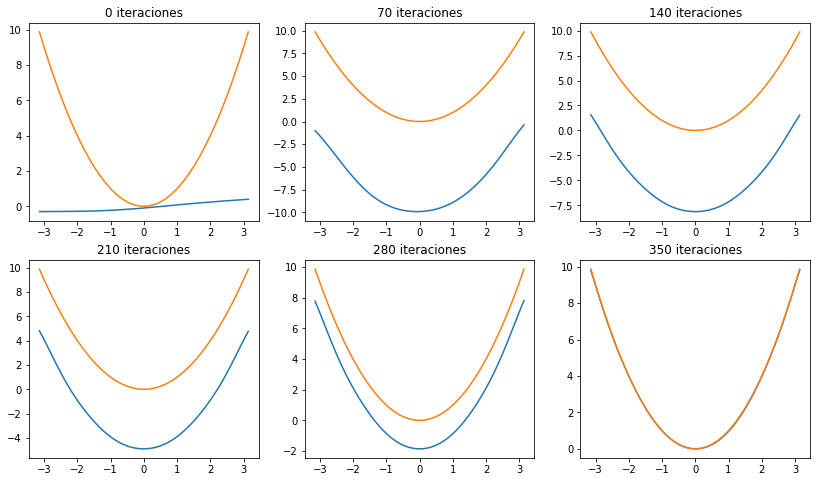

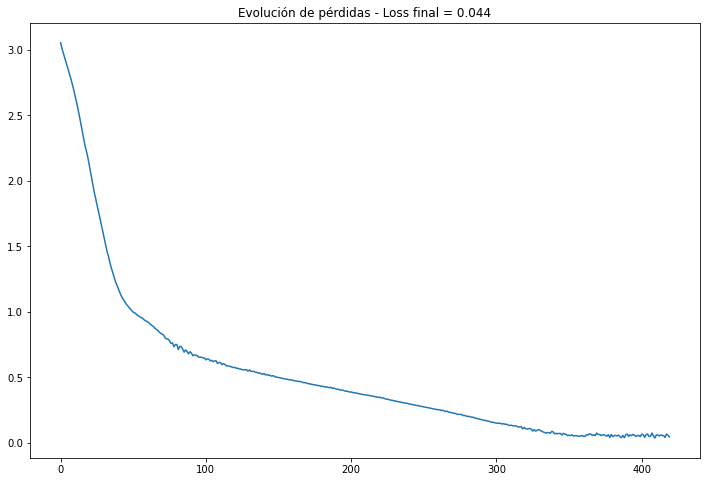

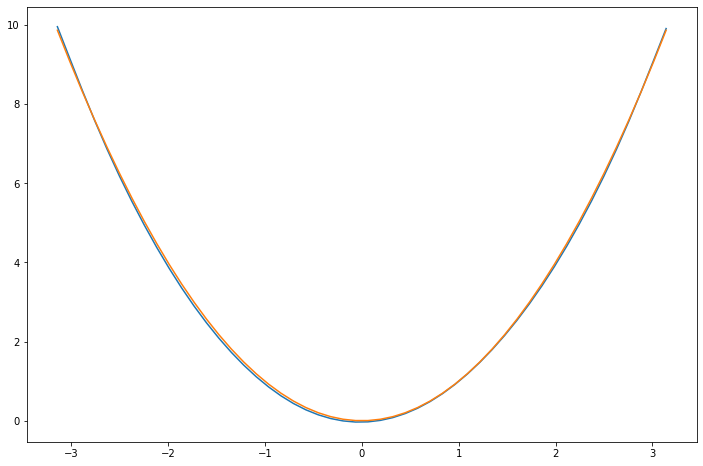

In [12]:
model.load_state_dict(params_iniciales)

N_sample = 50
N_total = N_sample
x1 = torch.linspace(-pi,pi,50).reshape(50,1)
x = x1

alpha = 0.05 #0.05
optimizer = torch.optim.Adam(model.parameters(),lr=0.04)

n_epochs = 420 #420
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(14,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/6) == 0:
        y = model(x1)
        plt.subplot(2,3,int(i/int(n_epochs/6)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),f(x1))

plt.savefig('its_cuadratica_2.svg',bbox_inches='tight')
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]/N_total))
plt.plot(losses/N_total)
plt.savefig('losses_cuadratica_2.svg',bbox_inches='tight')

y = model(x1)
plt.figure(figsize=(12,8))
plt.plot(detach(x1),detach(y))
plt.plot(detach(x1),detach(f(x1)))
plt.savefig('resultado_cuadratica_2.svg',bbox_inches='tight')

El comportamiento del proceso de entrenamiento de este problema elucida muy bien lo que ocurre cuando se entrena usando una ecuación diferencial: la red se está entrenando para satisfacer dos condiciones separadas, la ecuación diferencial y la condición de frontera. O, puesto de una manera visualmente más diciente, la forma y la ubicación de la curva. En este caso, el valor tan bajo de $\alpha$ (alpha) que se tomó hace que la red favorezca la función diferencial durante su entrenamiento, lo que ocasiona que empiece a modificar primero la geometría de su salida a la de una parábola (la solución de la ecuación diferencial propuesta) y luego al alcanzar la forma correcta, procede a desplazarla hacia la posición deseada.

## Función senosoidal
## $\frac{df}{dx} = cos(x + \pi/4); f(0) = \frac{\sqrt{2}}{2}$

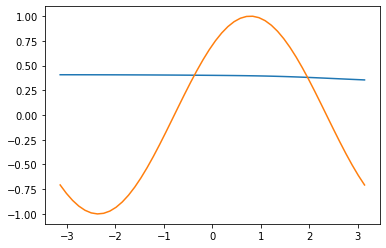

In [13]:
def jacobiano(x): # Crea el jacobiano del modelo con respecto a x, de una manera que es derivable.
    return dp.jacobian(model,x,create_graph=True)

def f(x):
    return torch.sin(x+pi/4)

def df(x):
    return torch.cos(x+pi/4)

def error(x): 
    return torch.abs(jacobiano(x)-df(x))

def error_frontera():
    return torch.abs(model(tensor([0.]))-f(tensor(0.)))

def residuales(X):
    alpha = 0.2
    res = 0
    for x in X:
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res

model = torch.nn.Sequential(torch.nn.Linear(1,3),
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,1) )

params_iniciales = copy.deepcopy(model.state_dict())

N_sample = 50
x0 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1)
y0 = model(x0)

plt.plot(detach(x0),detach(y0))
plt.plot(detach(x0),f(x0))

Tiempo promedio:	 0.04288435142857143


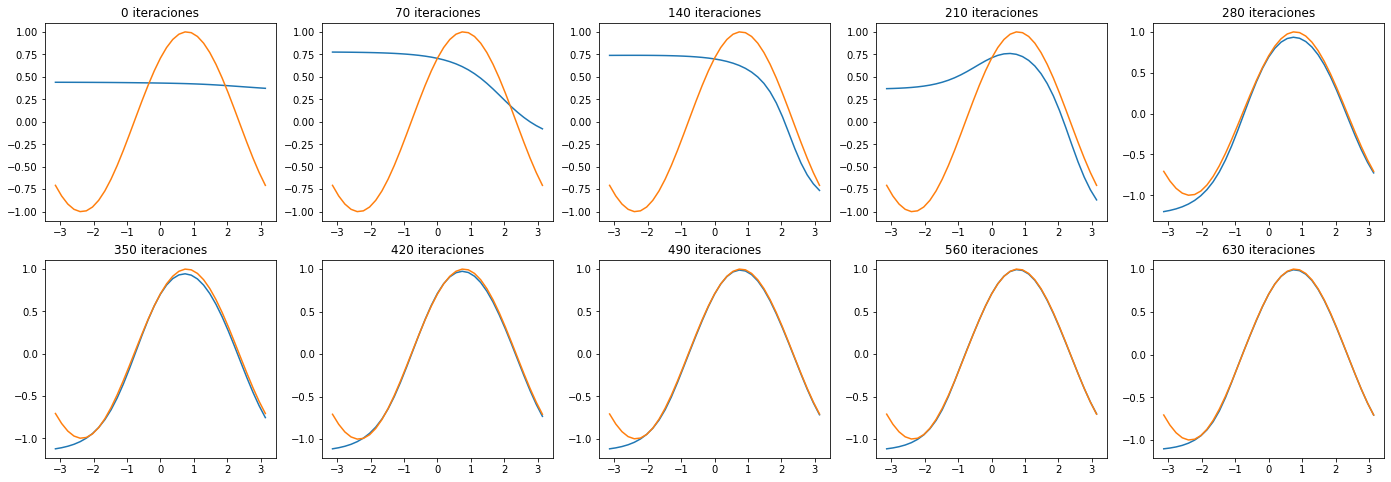

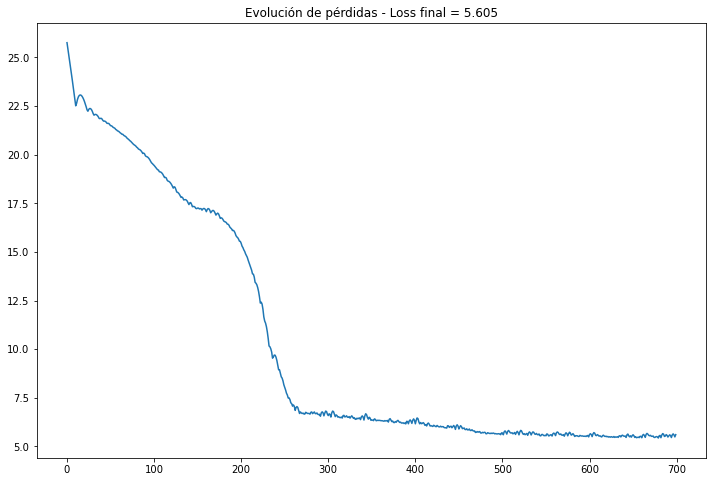

In [14]:
model.load_state_dict(params_iniciales)

N_sample = 35
N_complement = 15

x1 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1)
x2 = torch.linspace(-pi,-1.5,N_complement).reshape(N_complement,1) # Se hace el sampleo adicional
x = torch.vstack((x1,x2))
    #La distribución beta se ve prometedora. Con alpha = beta, beta grande para distribución central. Con alfa = 1, beta grande para fronteras. La moda se puede calibrar con la fórumla
    #La chi2 podría utilizarse

optimizer = torch.optim.Adam(model.parameters(),lr=0.004)

n_epochs = 700
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/10) == 0:
        y = model(x1)
        plt.subplot(2,5,int(i/int(n_epochs/10)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),f(x1))
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]))
plt.plot(losses)

## Función exponencial
## $\frac{dy}{dx} = y ; y(0) = 1; y(1) = e$

Ahora se intenta entrenar el modelo con una ecuación diferencial de la forma $y'(x) = f(y)$, en este caso se toma la ecuación más sencilla de este tipo, una exponencial.

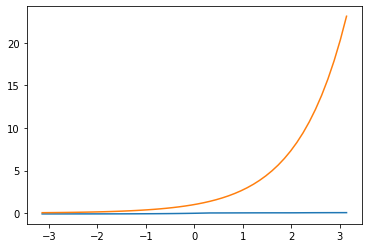

In [15]:
def jacobiano(x):
    return dp.jacobian(model,x,create_graph=True)

def jacobiano(x):
    y = model(x)
    v = torch.ones(x.size())
    return grad(y,x,grad_outputs=v,create_graph=True)[0]

def f(x):
    return torch.exp(x)

def df(x):
    return model(x)

def error(x):
    return torch.abs( jacobiano(x)-df(x) )

def error_frontera():
    e1 = torch.abs( model(tensor([0.])) - f(tensor(0.)) )
    e2 = torch.abs( model(tensor([1.])) - f(tensor([1.])) )
    return e1 + e2

def residuales(X):
    global alpha
    res = 0
    for x in X:
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res


model = torch.nn.Sequential(torch.nn.Linear(1,3), # Para exponencial
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(3,1) )

params_iniciales = copy.deepcopy(model.state_dict())

N_sample = 50
x0 = torch.linspace(-pi,pi,N_sample,requires_grad=True).reshape(N_sample,1)
y0 = model(x0)

plt.plot(detach(x0),detach(y0))
plt.plot(detach(x0),detach(f(x0)) )

Tiempo promedio:	 0.07286889833333333


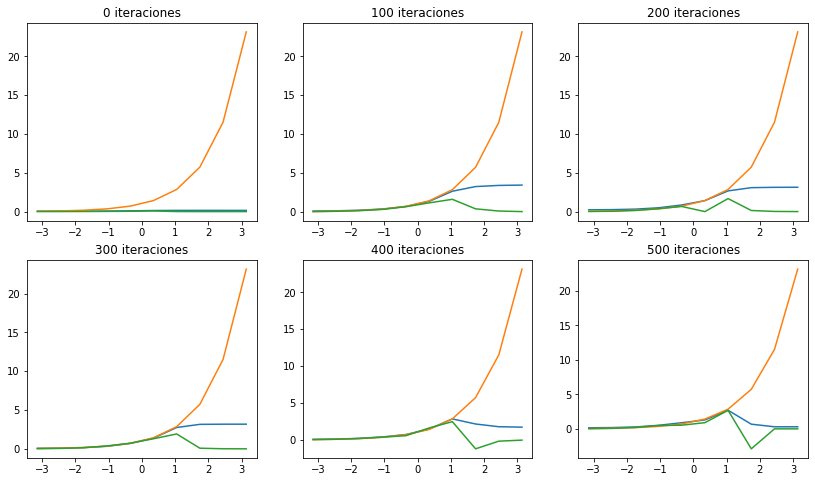

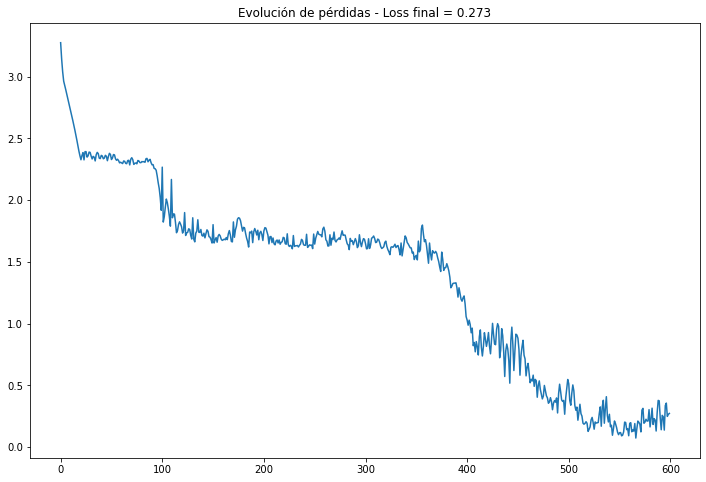

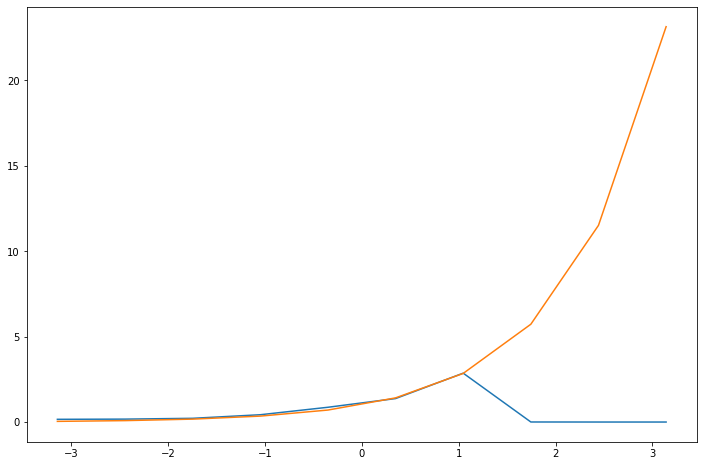

In [16]:
model.load_state_dict(params_iniciales)

alpha = 0.5
N_sample = 10
N_complement = 30
N_total = N_sample+N_complement

x1 = torch.linspace(-pi,pi,N_sample,requires_grad=True).reshape(N_sample,1)
x2 = torch.linspace(1-1e-1,1+1e-1,N_complement,requires_grad=True).reshape(N_complement,1) # Sampleo adicional cerca de condición de frontera
x3 = linspace(2,3,N_complement)
# x2 = torch.distributions.normal.Normal(1.,1.5).sample((N_complement,1))

x = torch.vstack((x1,x2,x3))

optimizer = torch.optim.Adam(model.parameters(),lr=4e-2)#, weight_decay=0.5)#,amsgrad=True)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

n_epochs = 600
loss_list = []
t1 = DT.datetime.now()

apportionment = []

plt.figure(figsize=(14,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/6) == 0:
        y = model(x1)
        plt.subplot(2,3,int(i/int(n_epochs/6)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),detach(f(x1)) )
        plt.plot(detach(x1),detach(jacobiano(x1)))

# plt.savefig('its_exponencial_2.0.svg',bbox_inches='tight')
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]/N_total))
plt.plot(losses/N_total)
# plt.savefig('losses_exponencial_2.0.svg',bbox_inches='tight')

y = model(x1)
plt.figure(figsize=(12,8))
plt.plot(detach(x1),detach(y))
plt.plot(detach(x1),detach(f(x1)))
# plt.savefig('resultado_exponencial_2.0.svg',bbox_inches='tight')

# Calcular alfa con una función en cada iteración. Qué dependa de i? O del error?
# Separar dominios

Se puede observar claramente cómo en este caso la red se ve incapaz de aproximar el comportamiento correcto. Esto se puede atribuir al hecho de que en los casos anteriores para cada punto de muestreo la red tenía la tarea clara de aproximar el valor de su derivada a un valor específico, mientras que en este caso, al entrenarse la red esta no tiene un valor fijo al cual acercarse: los valores de $y$ & $y'$ que definen la función de error cambian juntos, por lo cual la red se hace más propensa a buscar soluciones falsas, en tanto que este grado adicional de complejidad introduce varios mínimos locales con gradiantes mucho más fuertes que el mínimo global.

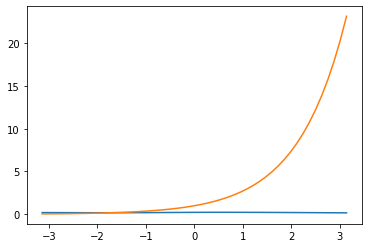

In [17]:
def jacobiano(x):
    return dp.jacobian(model,x,create_graph=True)

def jacobiano(x):
    y = model(x)
    v = torch.ones(x.size())
    return grad(y,x,grad_outputs=v,create_graph=True)[0]

def f(x):
    return torch.exp(x)

def df(x):
    return model(x)

def error(x):
    return torch.abs( jacobiano(x)-df(x) )

def error_frontera():
    e1 = torch.abs( model(tensor([0.])) - f(tensor(0.)) )
    e2 = torch.abs( model(tensor([1.])) - f(tensor([1.])) )
    return e1 + e2

def residuales(X):
    alpha = 0.1
    res = 0
    for x in X:
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res


model = torch.nn.Sequential(torch.nn.Linear(1,12),
                            torch.nn.Tanh(),
                            torch.nn.Linear(12,24), 
                            torch.nn.Tanh(),
                            torch.nn.Linear(24,12), 
                            torch.nn.Tanh(),
                            torch.nn.Linear(12,1)
                            )

params_iniciales = copy.deepcopy(model.state_dict())

N_sample = 50
x0 = torch.linspace(-pi,pi,N_sample,requires_grad=True).reshape(N_sample,1)
y0 = model(x0)

plt.plot(detach(x0),detach(y0))
plt.plot(detach(x0),detach(f(x0)) )

Tiempo promedio:	 0.023204189814814813


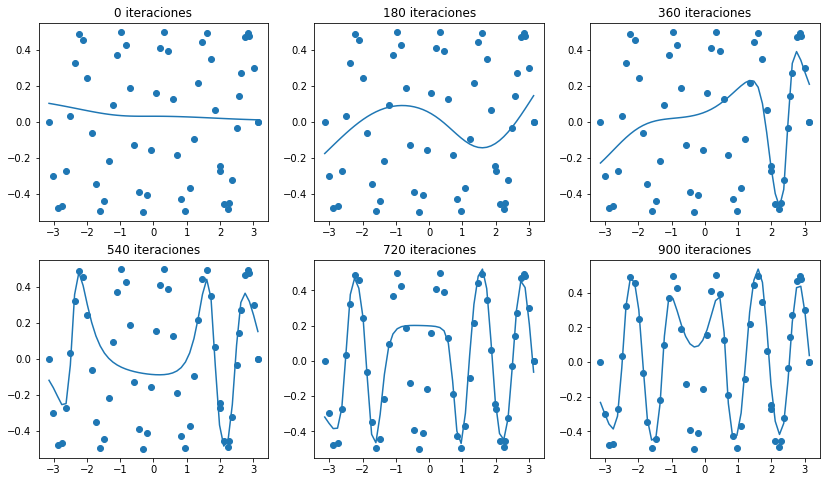

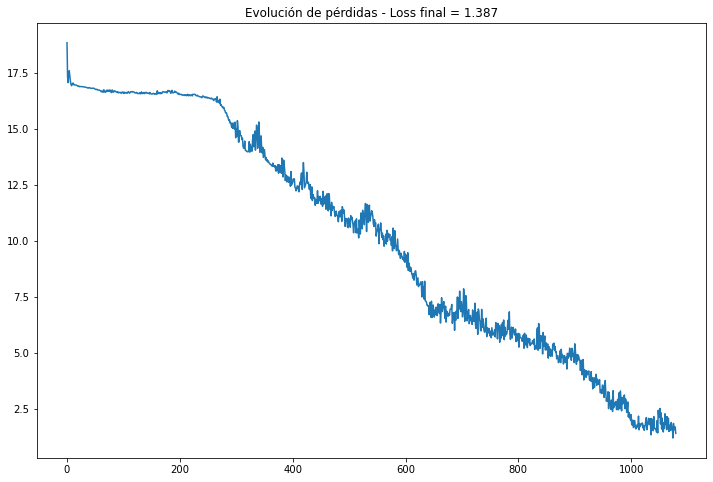

In [18]:
model = torch.nn.Sequential(torch.nn.Linear(1,12),
                            torch.nn.Tanh(),
                            torch.nn.Linear(12,24), 
                            torch.nn.Tanh(),
                            torch.nn.Linear(24,12), 
                            torch.nn.Tanh(),
                            torch.nn.Linear(12,1)
                            )
model.load_state_dict(params_iniciales)

def f_pre(x):
    A = 0.5
    k = 5.
    return A*torch.sin(k*x)

def error_pre(x):
    return torch.abs(model(x) - f_pre(x))

def residuales_pre(X):
    res = 0
    i = 0
    for x in X:
        res += error_pre(x)
        i+=1
    return res#/i

N_sample = 50
N_complement = 5
N_total = N_sample + N_complement

x1 = linspace(-pi,pi,N_sample)
x2 = linspace(2,pi,N_complement)
x = torch.vstack((x1,x2))
# x = x1


optimizer = torch.optim.Adam(model.parameters(),lr=0.0095)

n_epochs = 1080
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(14,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales_pre(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/6) == 0:
        y = model(x1)
        plt.subplot(2,3,int(i/int(n_epochs/6)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.scatter(detach(x),detach(f_pre(x)))

# plt.savefig('its_f_transfer1.svg',bbox_inches='tight')
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_pre1 = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]))
plt.plot(losses)

Tiempo promedio:	 0.011810875


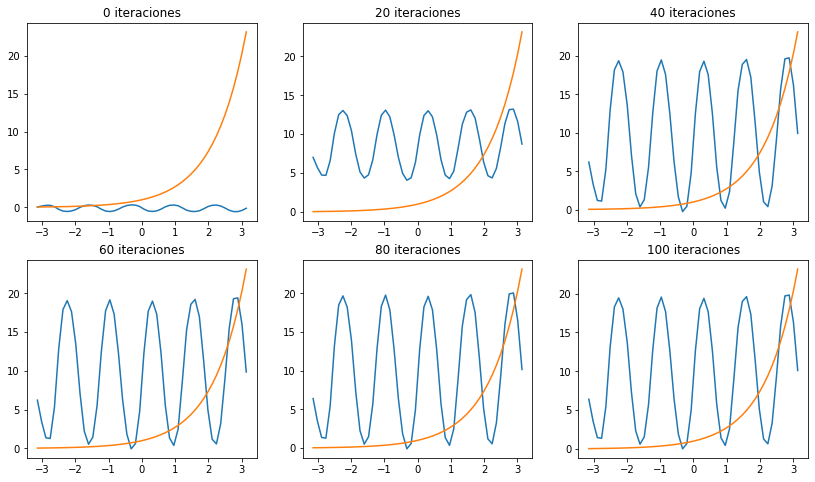

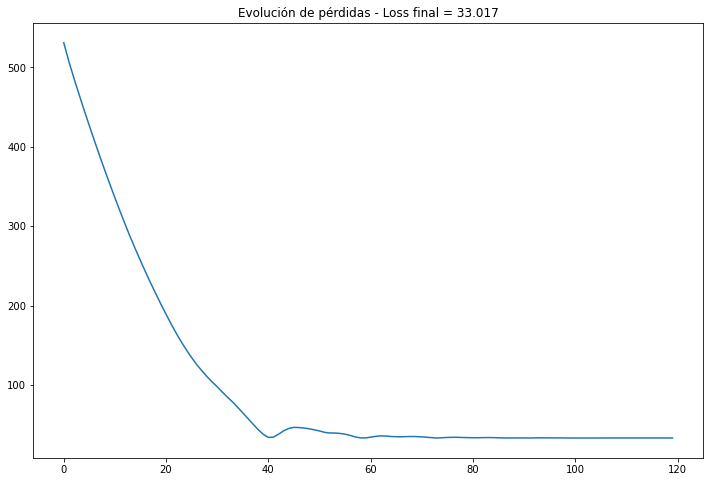

In [19]:
model = torch.nn.Sequential(torch.nn.Linear(1,12),
                            torch.nn.Tanh(),
                            torch.nn.Linear(12,24), 
                            torch.nn.Tanh(),
                            torch.nn.Linear(24,12), 
                            torch.nn.Tanh(),
                            torch.nn.Linear(12,1)
                            )

# torch.save(params_pre1,'modelos_PG/pre_senosoidal_1D.pt')

model.load_state_dict(params_pre1)
for p in model.parameters():
    p.requires_grad = False
    
model = torch.nn.Sequential(model,torch.nn.Linear(1,1))

def f_pre(x):
    A = 10.
    k = 5
    b = 10.
    return A*torch.sin(k*x) + b

N_sample = 50
N_total = N_sample

x1 = torch.linspace(-pi,pi,N_sample).reshape(N_sample,1)
x = x1

optimizer = torch.optim.Adam(model.parameters(),lr=0.5)

n_epochs = 120
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(14,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales_pre(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/6) == 0:
        y = model(x1)
        plt.subplot(2,3,int(i/int(n_epochs/6)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),f(x1))
#         plt.scatter(detach(x1),detach(f_pre(x1)))

# plt.savefig('its_f_transfer2.svg',bbox_inches='tight')
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_pre2 = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]))
plt.plot(losses)

Tiempo promedio:	 0.06083039761904762


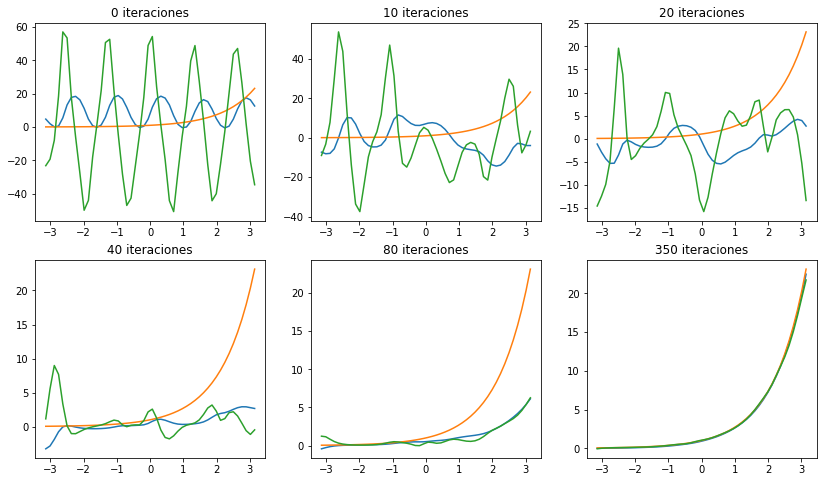

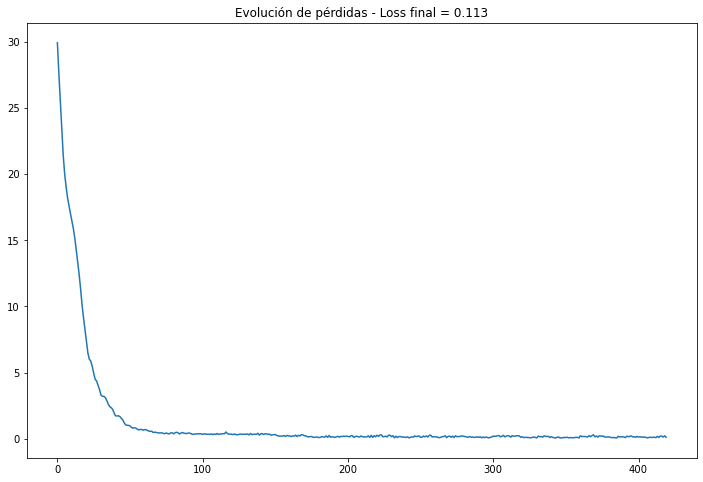

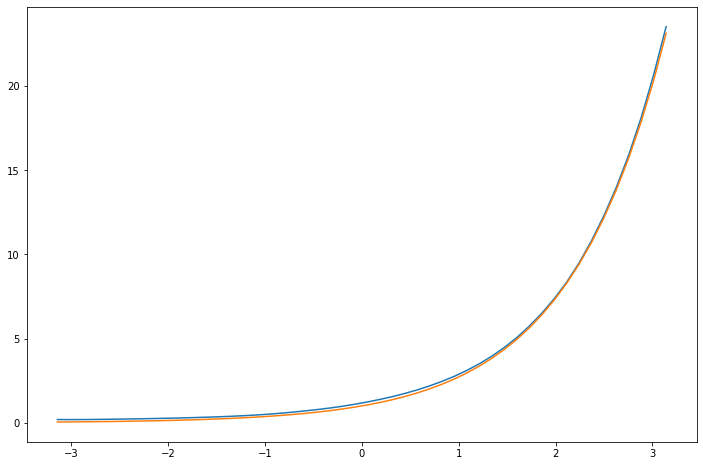

In [20]:
model.load_state_dict(params_pre2)

for p in model.parameters():
    p.requires_grad = True

N_sample = 50
N_complement = 5

N_total = N_sample

x1 = linspace(-pi,pi,N_sample)
x2 = torch.distributions.normal.Normal(0.,2).sample((N_complement,1))
x = torch.vstack((x1,x2))
x = x1

optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)

# alpha = 0.7
n_epochs = 420
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(14,8))
j = 1
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
#     if i% int(n_epochs/6) == 0:
    if i in [0,10,20,40,80,350]:
        y = model(x1)
        plt.subplot(2,3,j)
        j += 1
#         plt.subplot(2,3,int(i/int(n_epochs/6)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),detach(f(x1)) )
        plt.plot(detach(x1),detach(jacobiano(x1)))

plt.savefig('its_exponencial_2.1.svg',bbox_inches='tight')
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]/N_total))
plt.plot(losses/N_total)
plt.savefig('losses_exponencial_2.1.svg',bbox_inches='tight')

y = model(x1)
plt.figure(figsize=(12,8))
plt.plot(detach(x1),detach(y))
plt.plot(detach(x1),detach(f(x1)))
plt.savefig('resultado_exponencial_2.1.svg',bbox_inches='tight')

# Entrenar a partir de ecuaciones diferenciales de segundo orden
## Función senosoidal
## $\frac{d^2f}{dx^2}=-sin(x+\pi/4)$; $f(0) = sin(\pi/4)$; $f(1) = sin(1+\pi/4)$

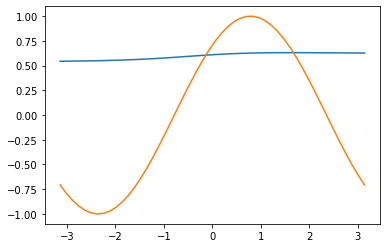

In [21]:
def jacobiano(x):
    return dp.jacobian(model,x,create_graph=True)

def segunda_derivada(x):
    dx = grad(model(x),x,create_graph=True)[0]
    dxx = grad(dx,x,create_graph=True)[0]
    return dxx
    
def f(x):
    return torch.sin(x+pi/4)

def d2f(x):
    return -f(x)

def error(x):
    return torch.abs(segunda_derivada(x) - d2f(x))

def error_frontera():
    e1 = torch.abs(model(tensor([0.]))-f(tensor(0.)))
    e2 = torch.abs(model(tensor([1.]))-f(tensor(1.)))
    return e1+e2

def residuales(X): # Cambiaré el alpha de 0.3 por 0.6 porque creo que no tiene suficiente incentivo para mejorar la curvatura. Consideraré aplicarle una transformación a la función de error
    alpha = 0.15    # Creo que le es muy fácil entrenar las condiciones de frontera, alphas bajos son buena idea
    res = 0
    for x in X:
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res

model = torch.nn.Sequential(torch.nn.Linear(1,3), # Para senosoidal
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,1) )


params_iniciales = copy.deepcopy(model.state_dict())

y0 = model(x0)

plt.plot(detach(x0),detach(y0))
plt.plot(detach(x0),detach(f(x0)))

Tiempo promedio:	 0.222684303


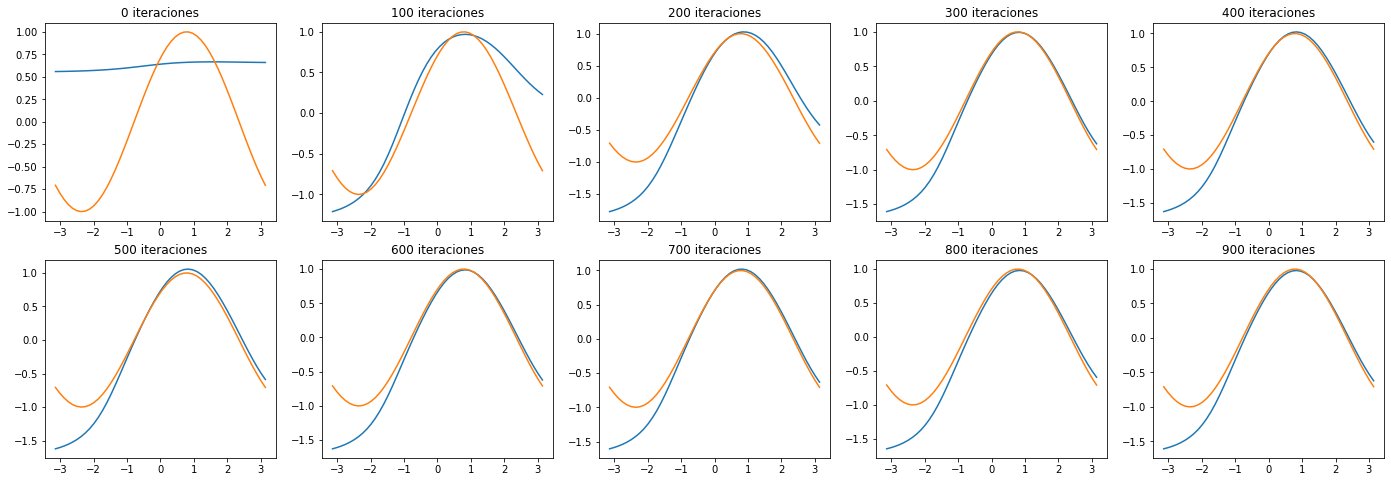

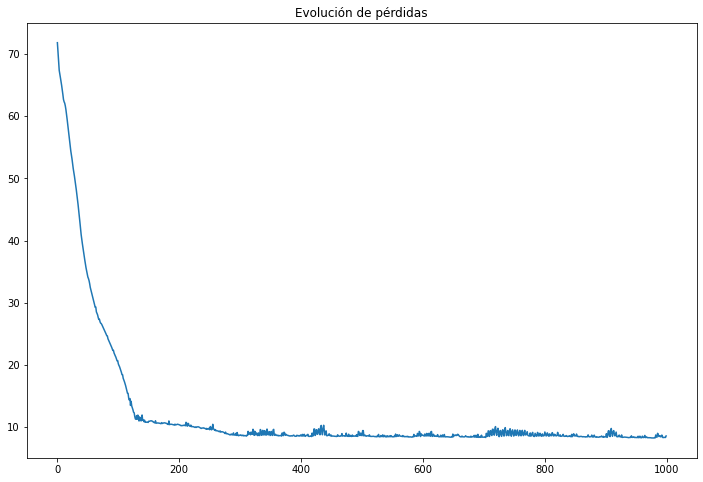

In [22]:
model.load_state_dict(params_iniciales)

N_dominio = 50
N_frontera1 = 10
N_frontera2 = 50

x1 = torch.linspace(-pi,pi,N_dominio,requires_grad=True).reshape(50,1)
x2 = torch.linspace(-pi/10,pi/10,N_frontera1,requires_grad=True).reshape(N_frontera1,1)
x3 = torch.linspace(-2,-2+2*pi/10,N_frontera2,requires_grad=True).reshape(N_frontera2,1)

x = torch.vstack((x1,x2,x3))

optimizer = torch.optim.Adam(model.parameters(),lr=0.0048)

n_epochs = 1000
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/10) == 0:
        y = model(x1)
        plt.subplot(2,5,int(i/int(n_epochs/10)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),detach(f(x1)))
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

## Función cuadrática
## $\frac{d^2f}{dx^2}=2$; $f(0) = 0$; $f(1) = 1$

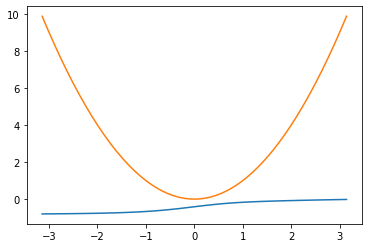

In [23]:
def jacobiano(x):
    return dp.jacobian(model,x,create_graph=True)

def segunda_derivada(x):
    dx = grad(model(x),x,create_graph=True)[0]
    dxx = grad(dx,x,create_graph=True)[0]
    return dxx
    
def f(x):
    return torch.pow(x,2)

def d2f(x):
    return tensor([2.],requires_grad=True)

def error(x):
    return torch.abs(segunda_derivada(x) - d2f(x))

def error_frontera():
    e1 = torch.abs(model(tensor([0.]))-f(tensor(0.)))
    e2 = torch.abs(model(tensor([1.]))-f(tensor(1.)))
    return e1+e2

def residuales(X): # Cambiaré el alpha de 0.3 por 0.6 porque creo que no tiene suficiente incentivo para mejorar la curvatura. Consideraré aplicarle una transformación a la función de error
    alpha = 0.15    # Creo que le es muy fácil entrenar las condiciones de frontera, alphas bajos son buena idea
    res = 0
    for x in X:
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res

model = torch.nn.Sequential(torch.nn.Linear(1,6),
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,1) )

params_iniciales = copy.deepcopy(model.state_dict())

x0 = torch.linspace(-pi,pi,N_dominio,requires_grad=True).reshape(50,1)

y0 = model(x0)

plt.plot(detach(x0),detach(y0))
plt.plot(detach(x0),detach(f(x0)))

Tiempo promedio:	 0.05084112833333333


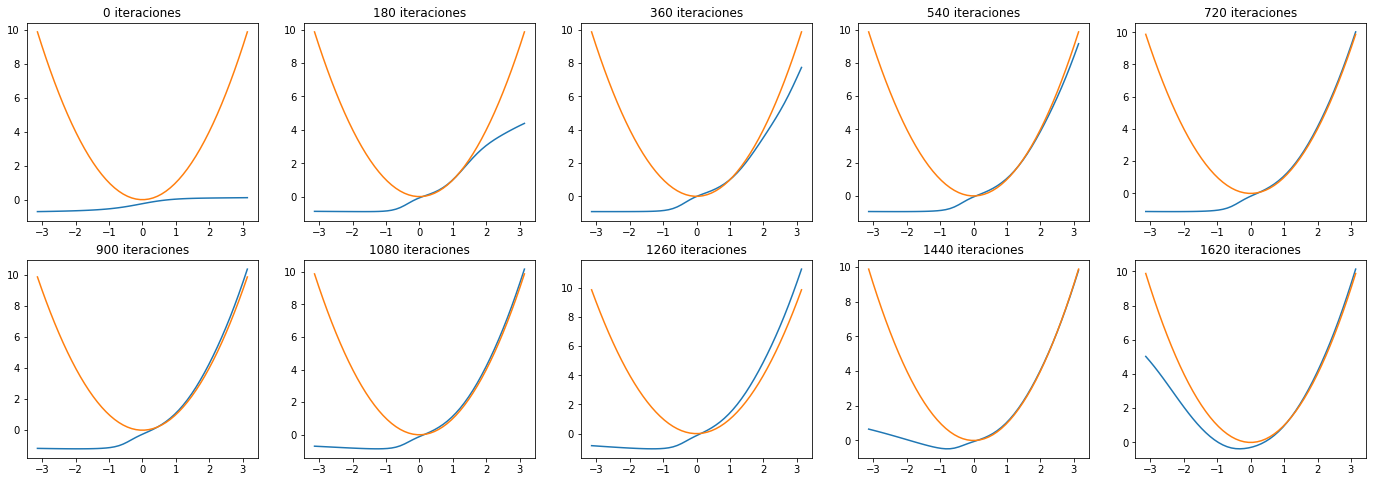

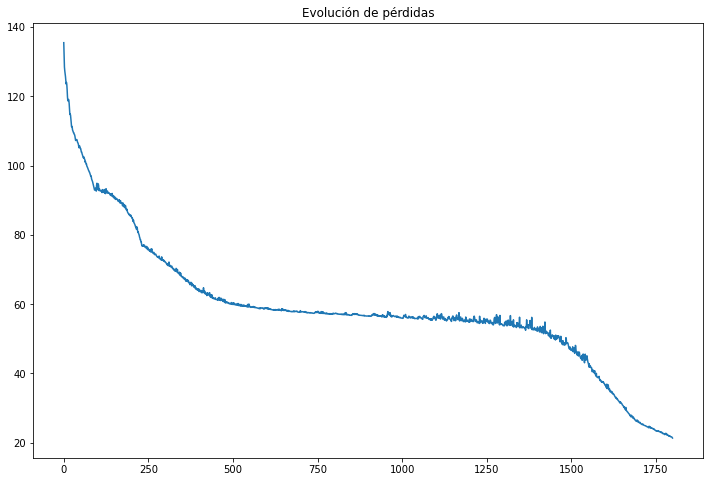

In [24]:
# Evitar operaciones in-place

model.load_state_dict(params_iniciales)


N_dominio = 50
N_frontera = 10

x1 = torch.linspace(-pi,pi,N_dominio,requires_grad=True).reshape(50,1)

x2 = torch.linspace(-1,-1+2*pi/10,N_frontera,requires_grad=True).reshape(N_frontera,1)
# Usar más puntos en la frontera es mejor que incrementar el alpha, parece ser. (incentivos relativos v. absolutos)
x3 = torch.linspace(1.-2*pi/10,1.,N_frontera,requires_grad=True).reshape(N_frontera,1)

# Es mejor utilizar condiciones de frontera en los extremos que en el dominio. Creo que es porque
# lo hace menos caótico i.e. un error muy pequeño en el centro puede resultar en errores grandes en la
# frontera, porque esta red sólo conoce su curvatura (no sus valores ni su tasa de cambio), le es muy
# sencillo aproximar una cuadrática distinta lejos de las condiciones dadas.


x = torch.vstack((x1,x2,x3))

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=0.035)

n_epochs = 1800
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/10) == 0:
        y = model(x1)
        plt.subplot(2,5,int(i/int(n_epochs/10)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),detach(f(x1)))
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

## Función exponencial

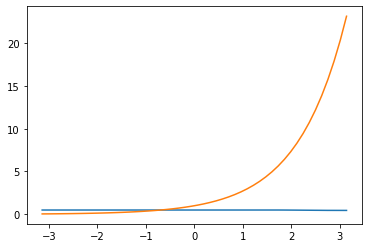

In [25]:
def jacobiano(x):
    return dp.jacobian(model,x,create_graph=True)

def segunda_derivada(x):
    dx = grad(model(x),x,create_graph=True)[0]
    dxx = grad(dx,x,create_graph=True)[0]
    return dxx
    
def f(x):
    return torch.exp(x)

def d2f(x):
    return f(x)

def error(x):
    return torch.abs(segunda_derivada(x) - d2f(x))

def error_frontera():
    e1 = torch.abs(model(tensor([-1.]))-f(tensor(-1.)))
    e2 = torch.abs(model(tensor([pi]))-f(tensor(pi)))
    return e1+e2

def residuales(X): # Cambiaré el alpha de 0.3 por 0.6 porque creo que no tiene suficiente incentivo para mejorar la curvatura. Consideraré aplicarle una transformación a la función de error
    alpha = 0.12    # Creo que le es muy fácil entrenar las condiciones de frontera, alphas bajos son buena idea
    res = 0
    for x in X:
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res



model = torch.nn.Sequential(torch.nn.Linear(1,3), # Para exponencial
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(3,1) )

params_iniciales = copy.deepcopy(model.state_dict())

N_dominio = 50
N_frontera = 10

x = tensor([1.])
x1 = torch.linspace(-pi,pi,N_dominio,requires_grad=True).reshape(50,1)
x2 = torch.linspace(-1,-1+2*pi/10,N_frontera,requires_grad=True).reshape(N_frontera,1)
x3 = torch.linspace(pi-2*pi/10,pi,N_frontera,requires_grad=True).reshape(N_frontera,1)
x = torch.vstack((x1,x2,x3))
y = model(x1)

plt.plot(detach(x1),detach(y))
plt.plot(detach(x1),detach(f(x1)))

Tiempo promedio:	 0.097029009


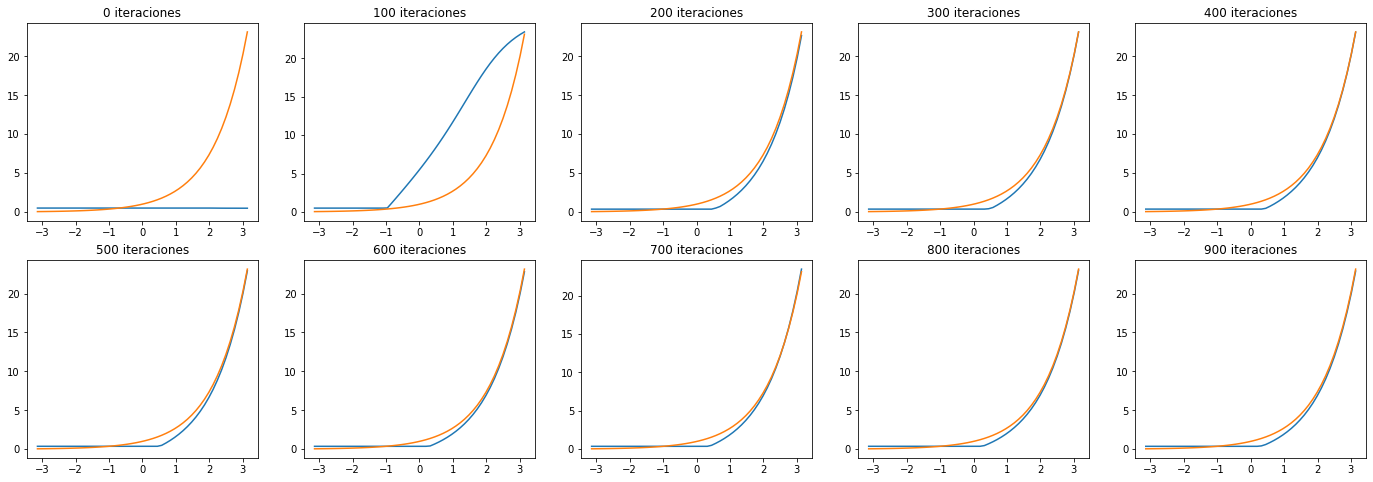

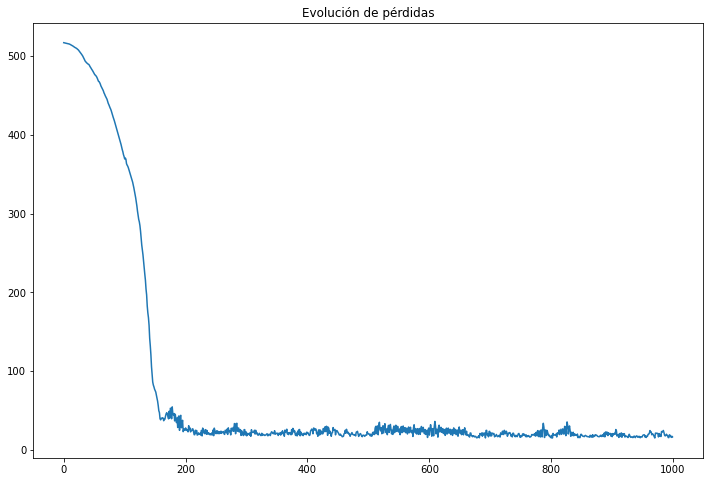

In [26]:
model.load_state_dict(params_iniciales)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

n_epochs = 1000
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/10) == 0:
        y = model(x1)
        plt.subplot(2,5,int(i/int(n_epochs/10)+1))
        plt.title(str(i)+" iteraciones")
        plt.plot(detach(x1),detach(y))
        plt.plot(detach(x1),detach(f(x1)))
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

# Entrenar campos escalares tipo $f: \mathbb{R}^2 \rightarrow \mathbb{R}$
## Paraboloide: $ z = x^2 + y^2 $

torch.Size([500, 2])


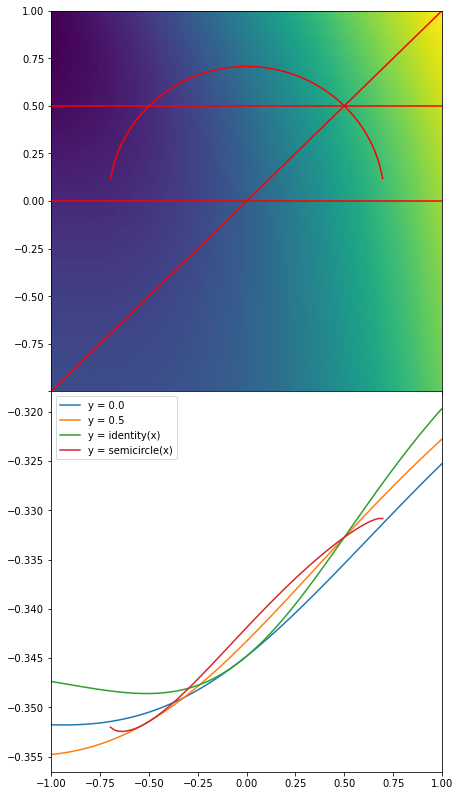

In [27]:
def f(x): # Funcion f(x,y) = x^2 + y^2
    return torch.sum(torch.pow(x,2))

def error(x):
    return torch.abs(model(x) - f(x))


def residuales(X):
    res = 0
    for x in X:
        res += error(x)
    return res


model = torch.nn.Sequential(torch.nn.Linear(2,3),
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,1) )

params_iniciales = copy.deepcopy(model.state_dict())

N_dominio = 500
a = -1
b = 1

xy = a + (b-a)*torch.rand(N_dominio,2) # N_dominio pares de números aleatorios entre a y b
# x1 = torch.FloatTensor(N_dominio,2).uniform_(N_dominio)
x = xy
print(x.shape)

z = model(xy)
def semicircle(x):
    return torch.sqrt(0.5-torch.pow(x,2))
def identity(x):
    return x

cortes = (0.,0.5,identity,semicircle)

plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes))
# plt.savefig('campoEscalar1_inicio.svg',bbox_inches='tight')

Tiempo promedio:	 0.23058171875


<Figure size 1728x576 with 0 Axes>

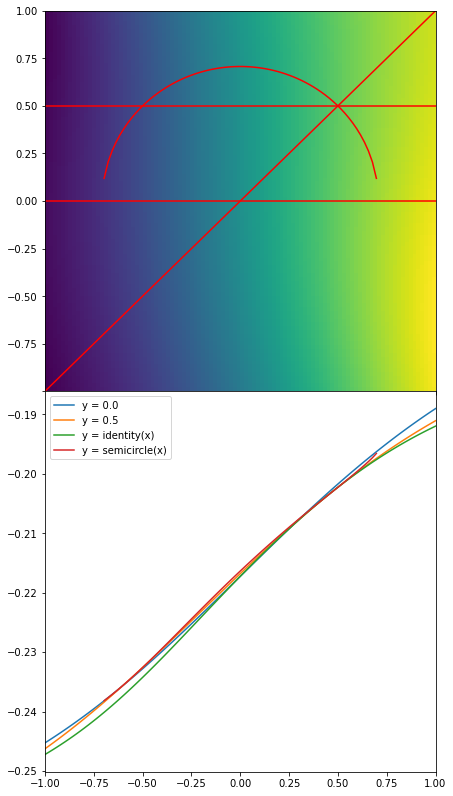

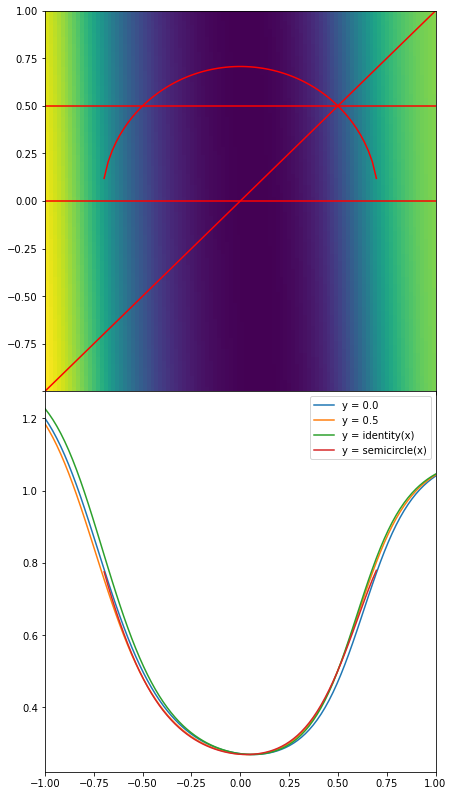

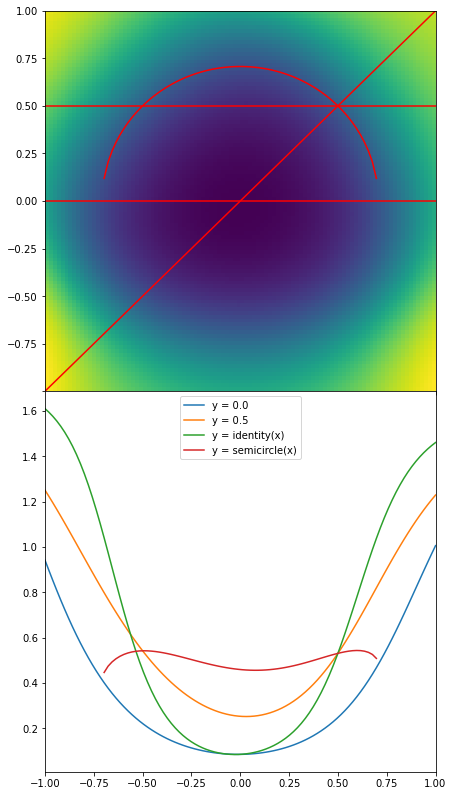

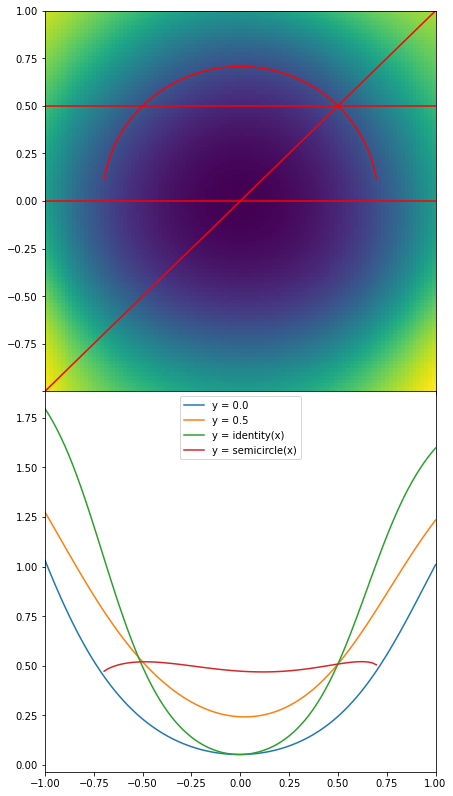

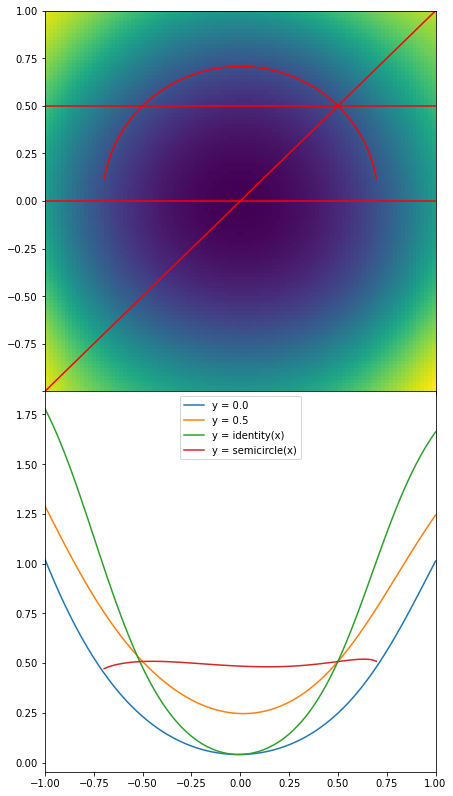

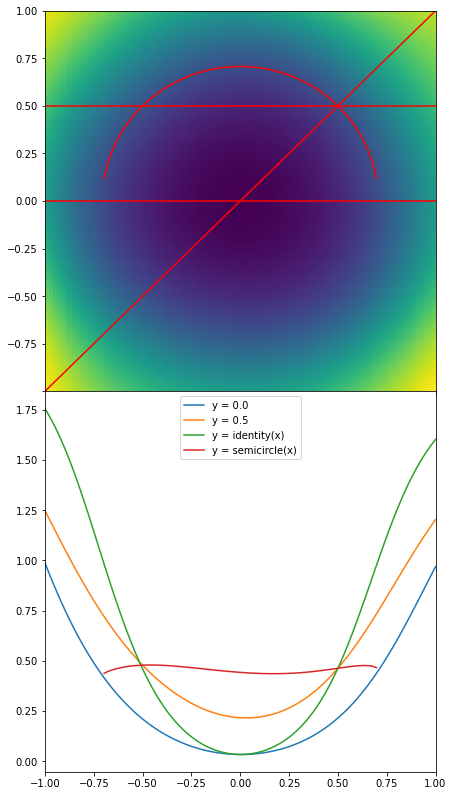

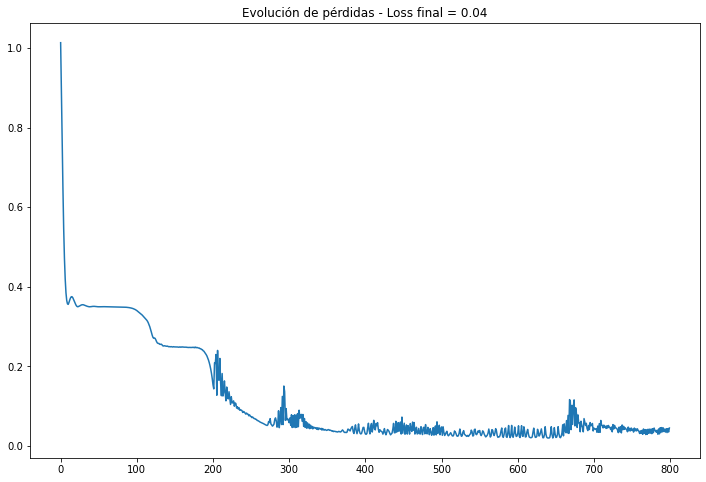

In [28]:
model.load_state_dict(params_iniciales)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=0.02)

n_epochs = 800
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model, rango=((a,b),(a,b)), plot_cut=('y',cortes) )
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

plot2D(model, rango=((a,b),(a,b)), plot_cut=('y',cortes) )
# plt.savefig('campoEscalar1_final.svg',bbox_inches='tight')

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.2f}'.format(losses[-1]/N_dominio))
plt.plot(losses/N_dominio)
# plt.savefig('campoEscalar1_losses.svg',bbox_inches='tight')

## Silla de montar: $z = xy$

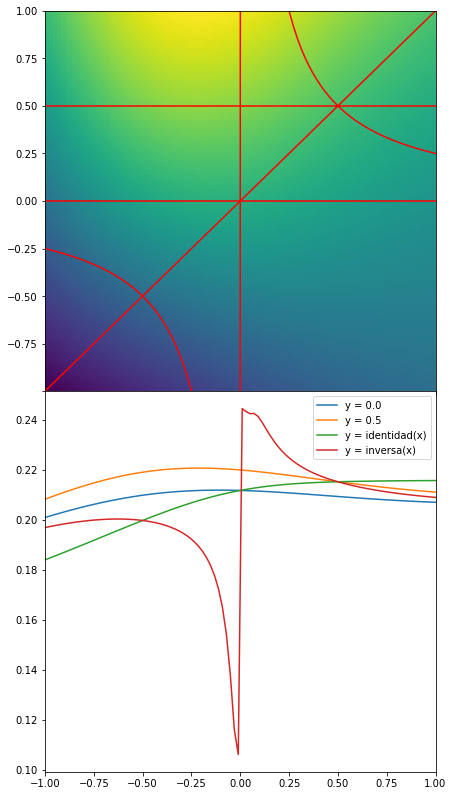

In [29]:
def f(x): # Funcion f(x,y) = x^2 + y^2
    return torch.sum(torch.prod(x))

def error(x):
    return torch.abs(model(x) - f(x))


def residuales(X):
    res = 0
    for x in X:
        res += error(x)
    return res


model = torch.nn.Sequential(torch.nn.Linear(2,3), # Para exponencial
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,1) )

params_iniciales = copy.deepcopy(model.state_dict())

N_dominio = 1000
a = -1
b = 1
def identidad(x):
    return x
def inversa(x):
    return 0.25*torch.pow(x,-1)
cortes = (0.,0.5,identidad,inversa)

xy = a + (b-a)*torch.rand(N_dominio,2) # N_dominio pares de números aleatorios entre a y b
# x1 = torch.FloatTensor(N_dominio,2).uniform_(N_dominio)
x = xy
z = model(xy)
plot2D(model, rango=((a,b),(a,b)), plot_cut=('y',cortes) )

Tiempo promedio:	 0.44331339


<Figure size 1728x576 with 0 Axes>

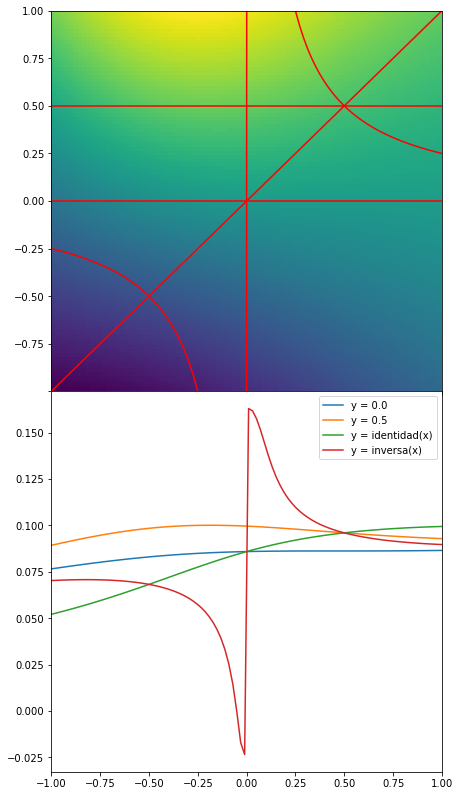

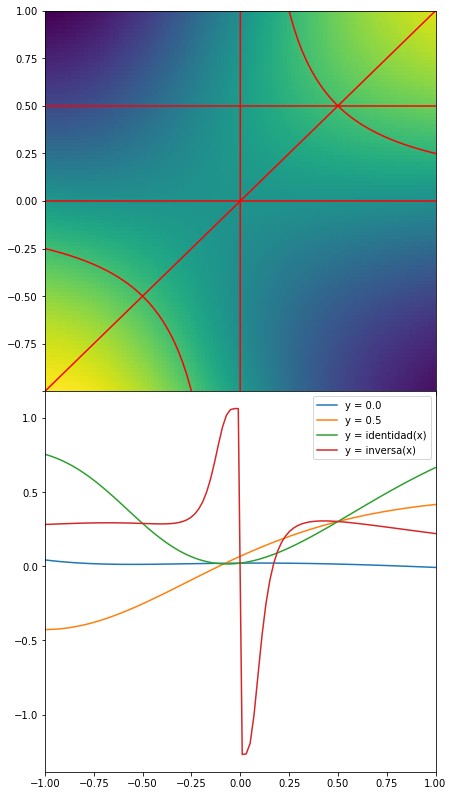

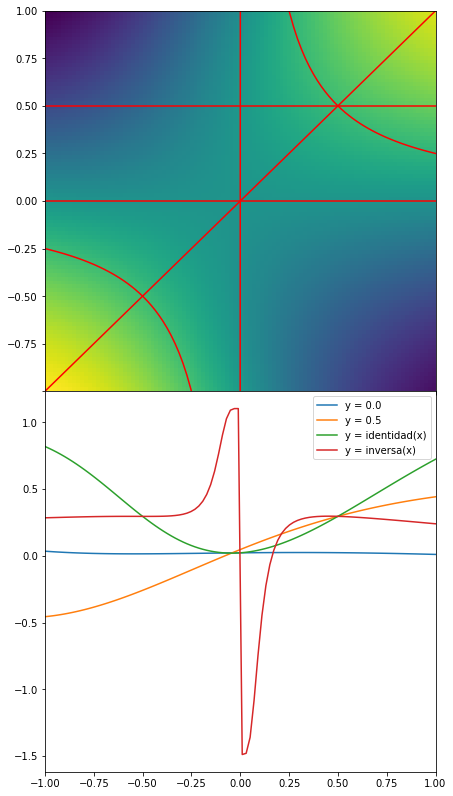

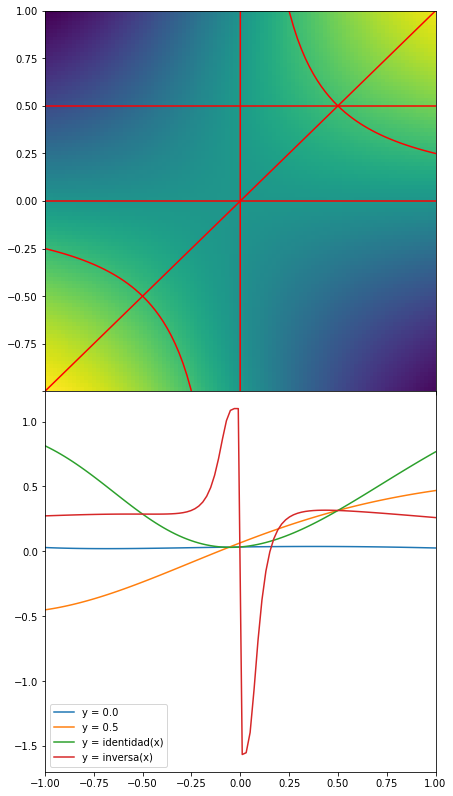

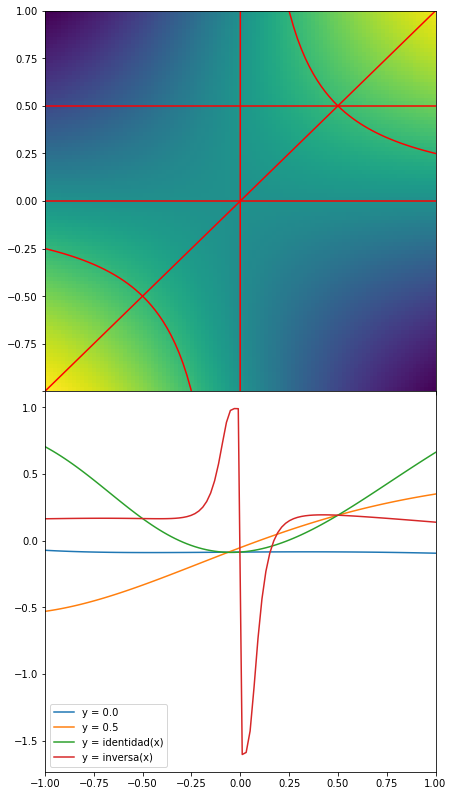

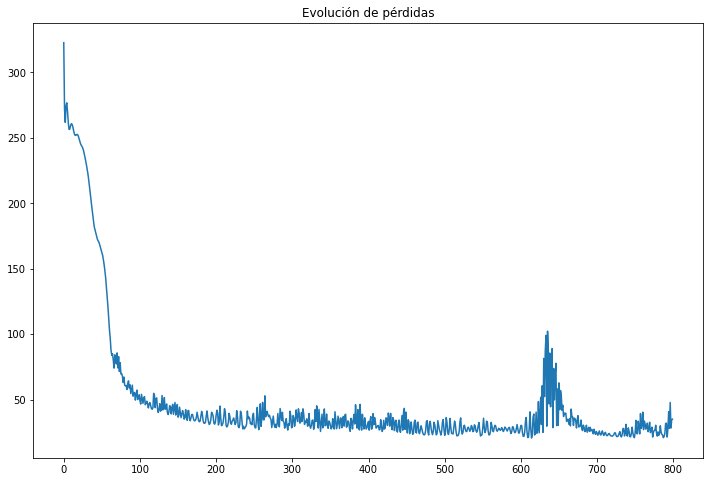

In [30]:
model.load_state_dict(params_iniciales)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=1.5e-2)

n_epochs = 800
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model, rango=((a,b),(a,b)), plot_cut=('y',cortes) )
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

# Campos vectoriales tipo $f: \mathbb{R}^2 \rightarrow \mathbb{R}^2$

## $f(x,y) = x+y,x-y$

torch.Size([500, 2])
torch.Size([500, 2])


tensor(847.1997, grad_fn=<AddBackward0>)

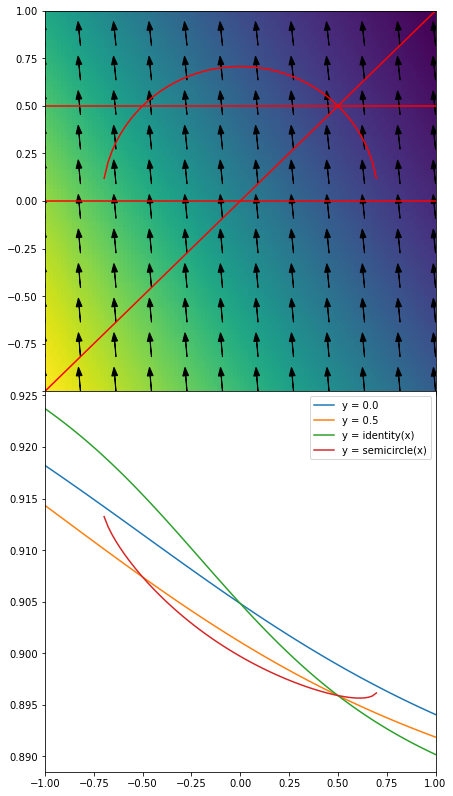

In [31]:
# def f(x): # Funcion f(x,y) = x+y,x-y
#     u = x[:,0]+x[:,1]
#     v =  x[:,0]-x[:,1]
#     return torch.vstack( (u,v) )

def f(x): # Hay que mirar tiempo
    A = torch.tensor([[1.,1.],[1.,-1.]], requires_grad=True)
    if len(x.size()) == 1:
        return A@x
    elif len(x.size()) == 2: # Sólo funciona para vectores o vectores de vectores (matrices)
        return (A@x.transpose(0,1)).transpose(0,1)

def error(x):
    return torch.sum( torch.abs(model(x) - f(x)) ) # Uso torch.sum para que sume el error de cada dimensión.


def residuales(X):
    res = 0
    for x in X:
        res += error(x)
    return res

N_in = 2
N_out = 2
model = torch.nn.Sequential(torch.nn.Linear(N_in,3), # Para exponencial
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,N_out) )

params_iniciales = copy.deepcopy(model.state_dict())

N_dominio = 500
a = -1
b = 1

xy = a + (b-a)*torch.rand(N_dominio,2) # N_dominio pares de números aleatorios entre a y b
# x1 = torch.FloatTensor(N_dominio,2).uniform_(N_dominio)
x = xy
z = model(xy)
def semicircle(x):
    return torch.sqrt(0.5-torch.pow(x,2))
def identity(x):
    return x


cortes = (0.,0.5,identity,semicircle)
plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
# plt.savefig('campoVectorial_inicio.svg',bbox_inches='tight')

print(xy.size())
print(f(xy).size())
# f(xy)
residuales(x)

Tiempo promedio:	 0.2913238425


<Figure size 1728x576 with 0 Axes>

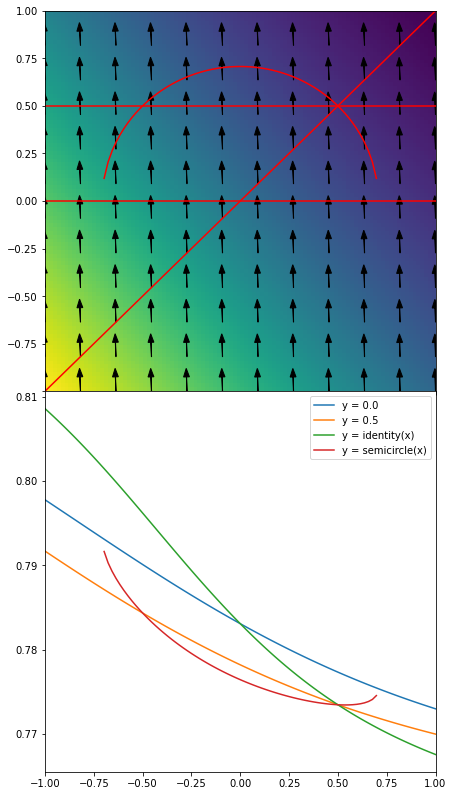

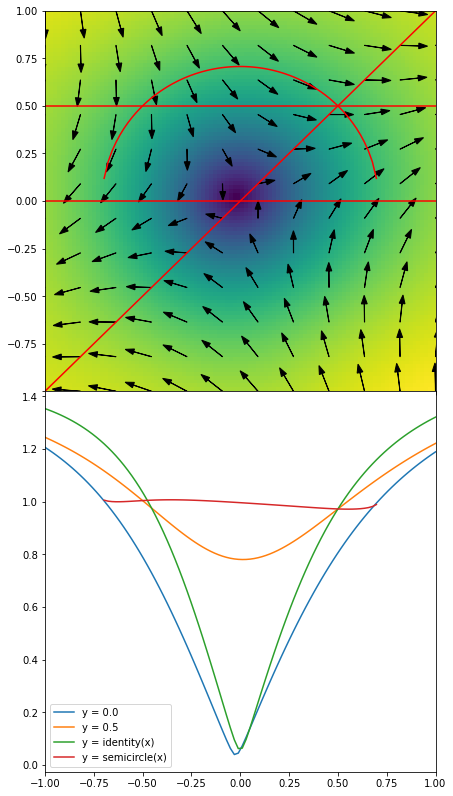

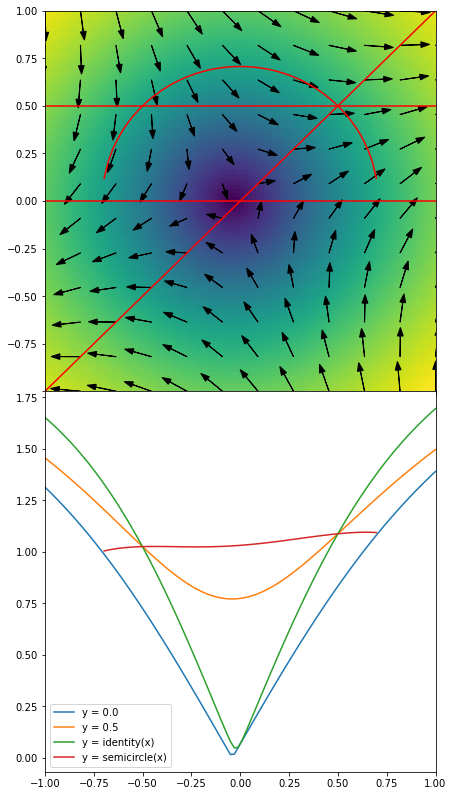

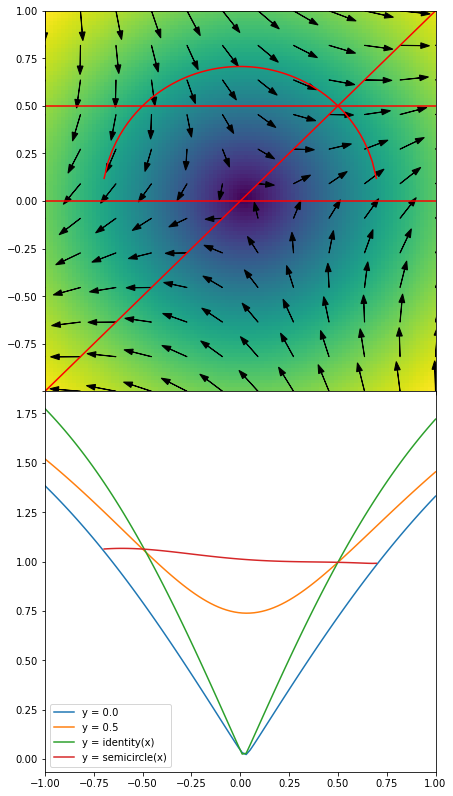

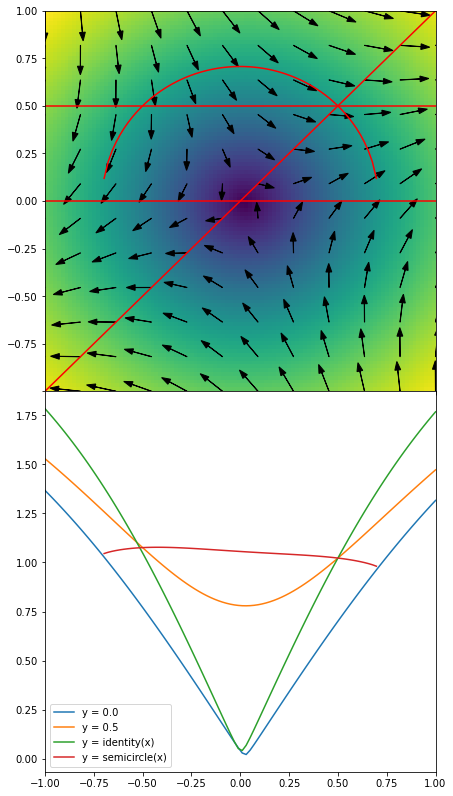

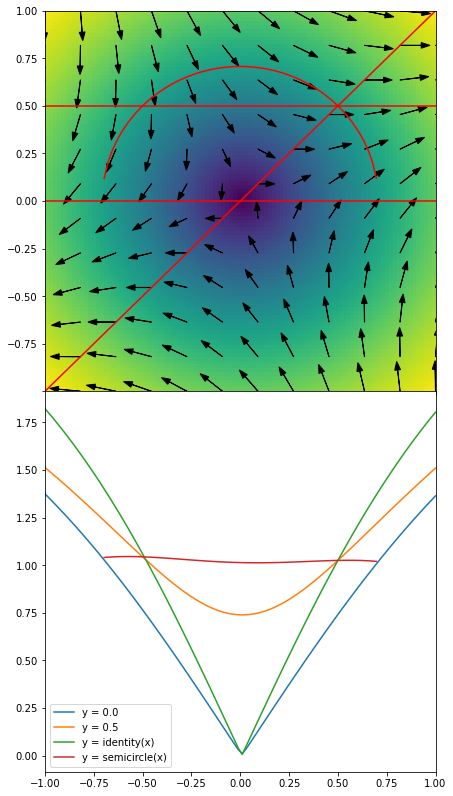

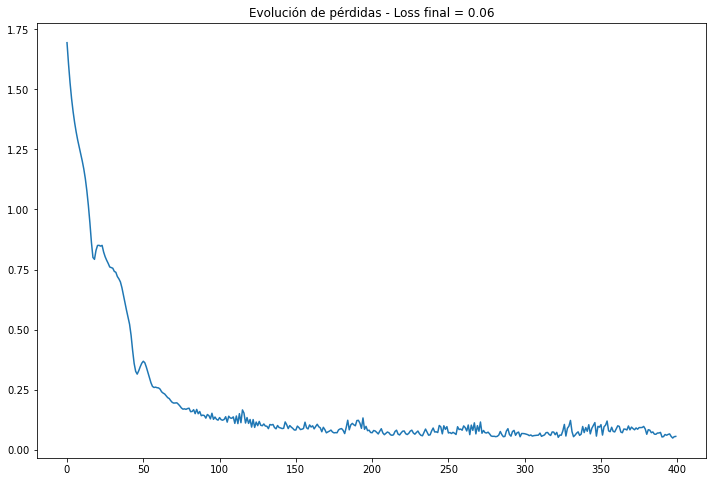

In [32]:
model.load_state_dict(params_iniciales)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=0.02)

n_epochs = 400
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
plt.savefig('campoVectorial_final.svg',bbox_inches='tight')

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.2f}'.format(losses[-1]/N_dominio))
plt.plot(losses/N_dominio)
plt.savefig('campoVectorial_losses.svg',bbox_inches='tight')

## Ecuación de Navier-Stokes estacionaria con presión conocida (para un flujo no-real)
##
## $p = 2x$
## $(u \cdot \nabla)u = -\nabla p + \frac{1}{Re}\nabla^2u$

torch.Size([500, 2])
torch.Size([500, 2])


tensor(65451.4648, grad_fn=<AddBackward0>)

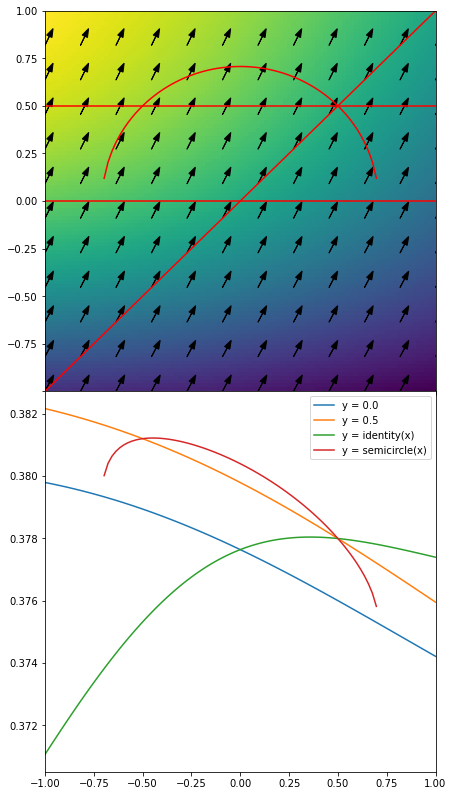

In [33]:
def jacobian(X,f):
    # Transposed!!: esta función retorna el jacobiano en la forma convencional, no en la forma transpuesta que usa torch
    basis = [torch.tensor([1.,0.]).reshape(1,2) , torch.tensor([0.,1.]).reshape(1,2)]
    
    if len(X.size()) == 1 or X.size()[0]==1:
        o = basis[0]
        J = grad(f(X),X,grad_outputs=o,create_graph=True)[0]
        for o in basis[1:]:
            g = grad(f(X),X,grad_outputs=o,create_graph=True)[0]
            J = torch.vstack([J,g])
        return J
    elif len(X.size()) == 2:
        x = X[0].reshape(1,2)
        o = basis[0]
        J = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
        for o in basis[1:]:
            g = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
            J = torch.vstack([J,g])
        Js = J.reshape(1,2,2) # Por qué ese arreglo? I dunno. Así es que lo entiende bien torch
        for x in X[1:]:
            x = x.reshape(1,2)
            o = basis[0]
            J = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
            for o in basis[1:]:
                g = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
                J = torch.vstack([J,g])
            Js = torch.vstack([Js,J.reshape(1,2,2)])
        return Js

def laplacian(X,f): # Para vectores o vectores de vectores (matrices Nx2)
    # Un transposed!! esta función retorna el laplaciano como vector fila, no en la forma convencional vector columna
    basis = [torch.tensor([1.,0.]).reshape(1,2) , torch.tensor([0.,1.]).reshape(1,2)]
    
    if len(X.size()) == 1 or X.size()[0]==1:
        ΔU = torch.zeros_like(f(X))
        for o1 in basis:
            g = grad(f(X),X,grad_outputs=o1,create_graph=True)[0]
            r = torch.zeros_like(g)
            for o2 in basis:
                gg = grad(g,X,grad_outputs=o2,create_graph=True)[0]
                r += o2*gg
            ΔU += o1*torch.sum(r)
        return ΔU
    
    elif len(X.size()) == 2:
        x = X[0].reshape(1,2)
        ΔU = torch.zeros_like(f(x))
        for o1 in basis:
            g = grad(f(x),x,grad_outputs=o1,create_graph=True)[0]
            r = torch.zeros_like(g)
            for o2 in basis:
                gg = grad(g,x,grad_outputs=o2,create_graph=True)[0]
                r += o2*gg
            ΔU += o1*torch.sum(r)
        for x in X[1:]:
            x = x.reshape(1,2)
            ΔUi = torch.zeros_like(f(x))
            for o1 in basis:
                g = grad(f(x),x,grad_outputs=o1,create_graph=True)[0]
                r = torch.zeros_like(g)
                for o2 in basis:
                    gg = grad(g,x,grad_outputs=o2,create_graph=True)[0]
                    r += o2*gg
                ΔUi += o1*torch.sum(r)
            ΔU = torch.vstack([ΔU,ΔUi])
    return ΔU


# X = tensor([0.,0.],requires_grad=True).reshape(1,2)
# U = model(X)
# J = jacobian(X,model)
# # print(dp.jacobian(model,X) )
# print(laplacian(X,model).T)

# print(J@U.T)

Re = 1
def f(x): # Hay que mirar tiempo
    A = torch.tensor([[1.,1.],[1.,-1.]], requires_grad=True)
    if len(x.size()) == 1:
        return A@x
    elif len(x.size()) == 2: # Sólo funciona para vectores o vectores de vectores (matrices)
        return (A@x.transpose(0,1)).transpose(0,1)


def error(x):
    U = model(x)
    J = jacobian(x,model)
    L = laplacian(x,model)
    div = torch.sum(torch.diagonal(J))
    
    HN = J@model(x).T - 1/Re*L.T - 2*x.T # Homogeneous navier, para grad p = 2x
    e12 = torch.sum( torch.abs(HN) )
    e3 = torch.abs(div)
#     return 0
    return torch.abs( e12 + e3 )

def error_frontera():
    line = linspace(-1,1)
    zeros = torch.zeros_like(line)
    r1,r2,r3,r4 = torch.hstack([line,zeros]),torch.hstack([zeros,line]),0,0
    e1 = torch.abs( model(r1)-f(r1) )
    e2 = torch.abs( model(r2)-f(r2) )
    e3,e4 = 0,0
    return torch.sum(e1+e2+e3+e4)


alpha = 0.6
def residuales(X):
#     print('Residuales')
    global alpha
    res = 0
    for x in X:
        x = x.reshape(1,2)
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res

def error_real(x):
    return torch.sum( torch.abs(model(x) - f(x)) ) # Uso torch.sum para que sume el error de cada dimensión.


def residuales_reales(X):
    res = 0
    for x in X:
        res += error_real(x)
    return res

N_in = 2
N_out = 2
model = torch.nn.Sequential(torch.nn.Linear(N_in,3), # Para exponencial
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,N_out) )

params_iniciales = copy.deepcopy(model.state_dict())

N_dominio = 500
a = -1
b = 1

xy = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True) # N_dominio pares de números aleatorios entre a y b
# x1 = torch.FloatTensor(N_dominio,2).uniform_(N_dominio)
x = xy
z = model(xy)
def semicircle(x):
    return torch.sqrt(0.5-torch.pow(x,2))
def identity(x):
    return x


cortes = (0.,0.5,identity,semicircle)
plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
# plt.savefig('campoNavier_inicio.svg',bbox_inches='tight')

print(xy.size())
print(f(xy).size())
# f(xy)
residuales(x)

Tiempo promedio:	 3.931677225


<Figure size 1728x576 with 0 Axes>

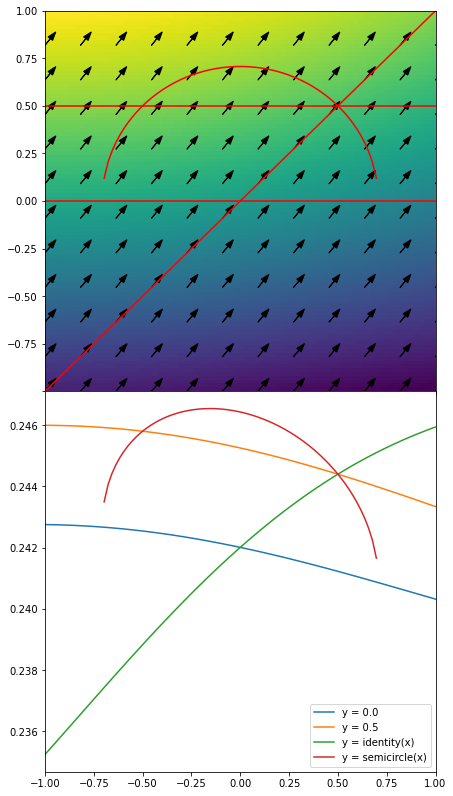

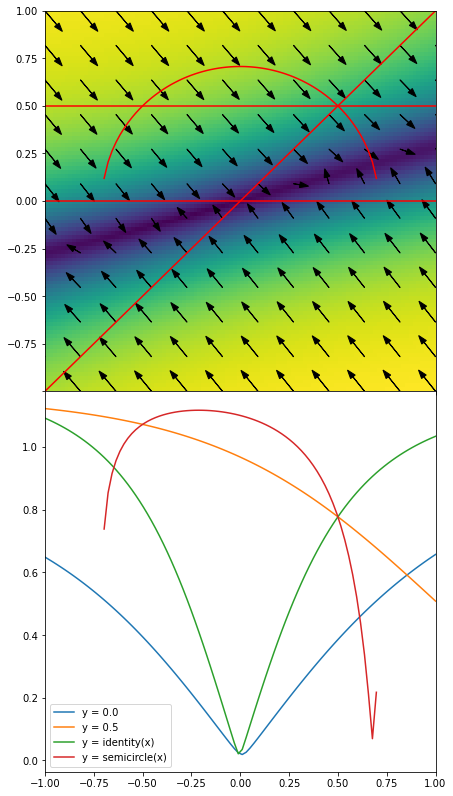

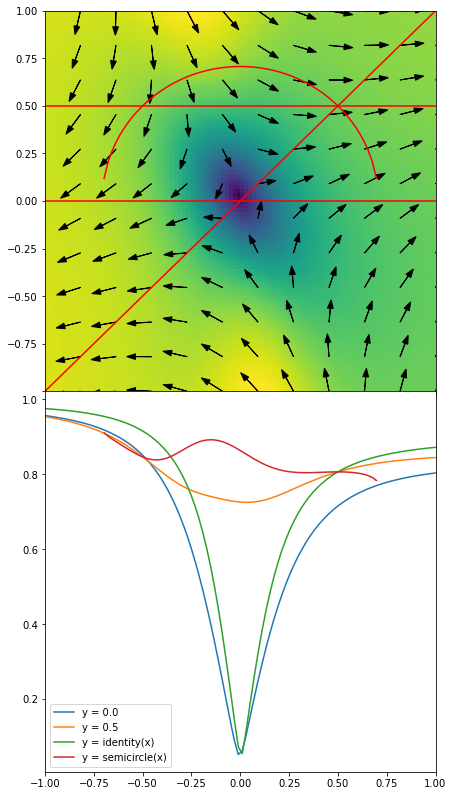

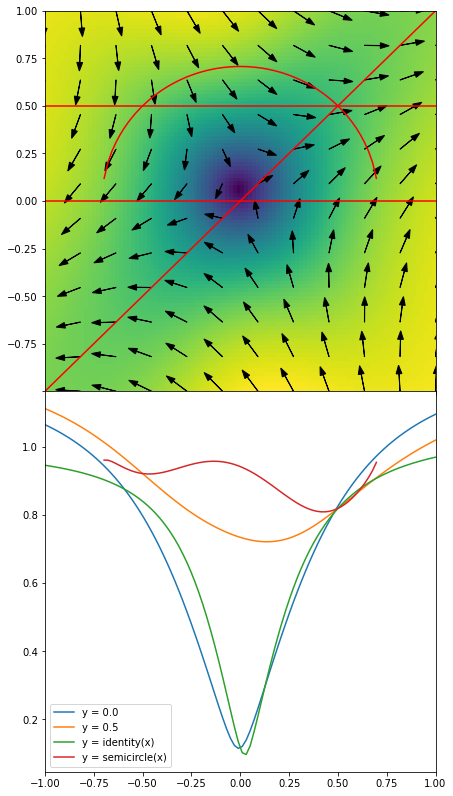

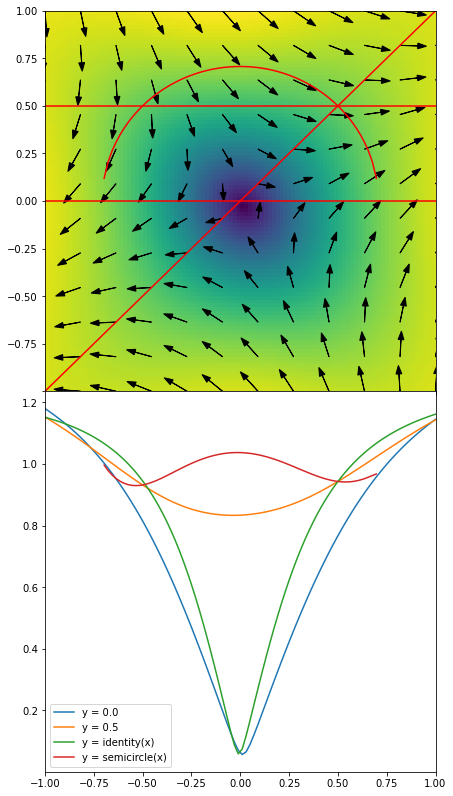

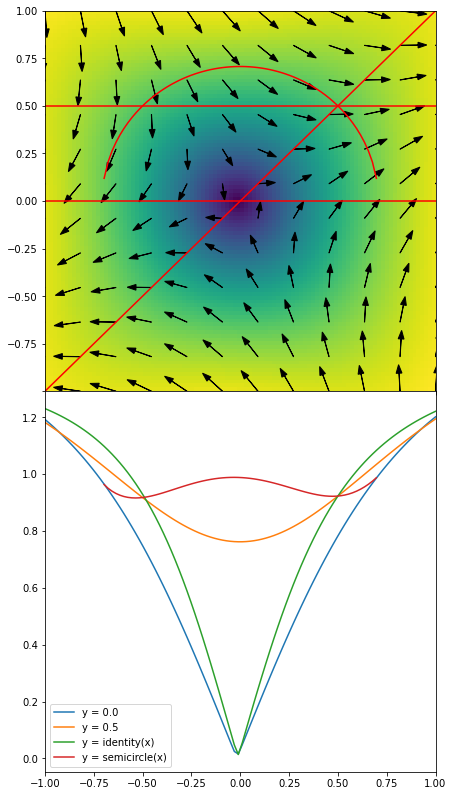

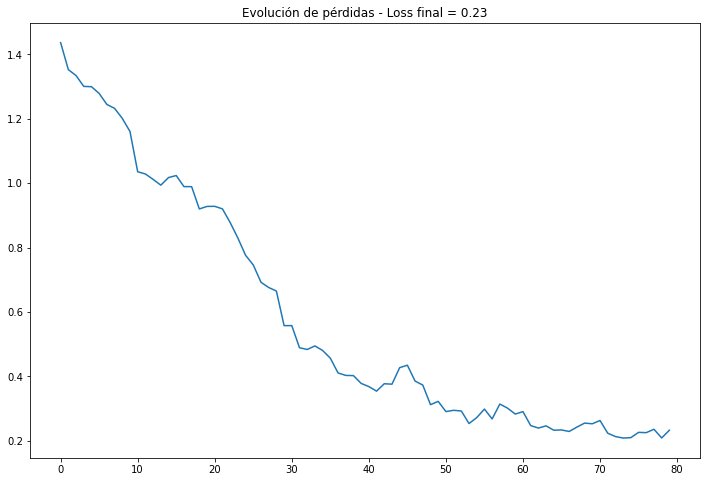

In [34]:
model.load_state_dict(params_iniciales)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=0.03)

alpha = 0.6
n_epochs = 80
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    x = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True)
    optimizer.zero_grad()
    loss = residuales(x)
    loss2 = residuales_reales(x)
    loss_list.append(loss2)
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
# plt.savefig('campoNavier_final.svg',bbox_inches='tight')

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.2f}'.format(losses[-1]/N_dominio))
plt.plot(losses/N_dominio)
plt.savefig('campoNavier_lossesreales.svg',bbox_inches='tight')

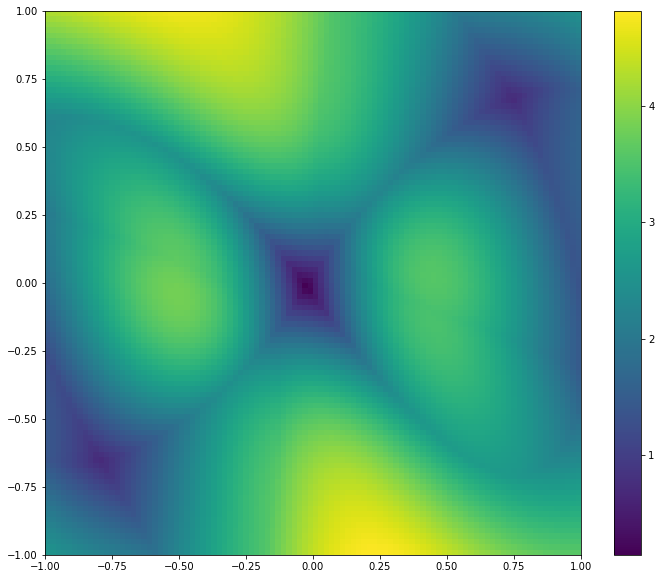

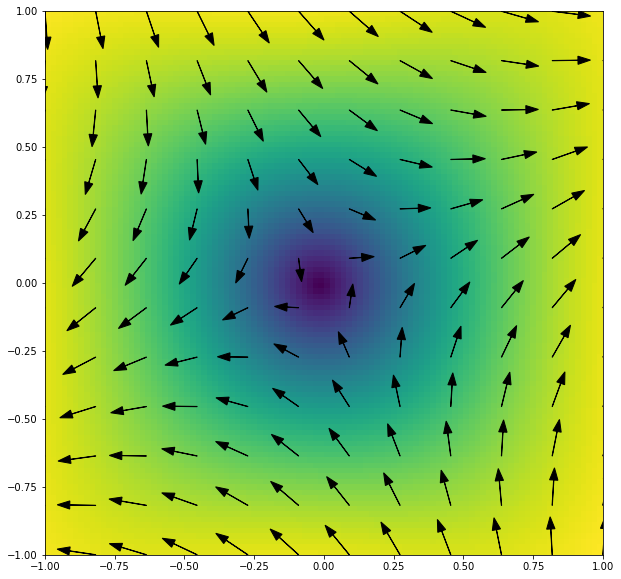

In [35]:
cortes = (0.,0.5,identity,semicircle)
fig,heatmap = plt.subplots(figsize=(12,10))
plot2D_error(model,rango=((a,b),(a,b)),axes=(heatmap,))
plt.savefig('campoNavier_loss2D.svg',bbox_inches='tight')

fig2,heatmap2 = plt.subplots(figsize=(10,10))
plot2D(model,rango=((a,b),(a,b)),N_salidas=2,axes=(heatmap2,))

torch.Size([500, 2])
torch.Size([500, 2])


tensor(611.1538, grad_fn=<AddBackward0>)

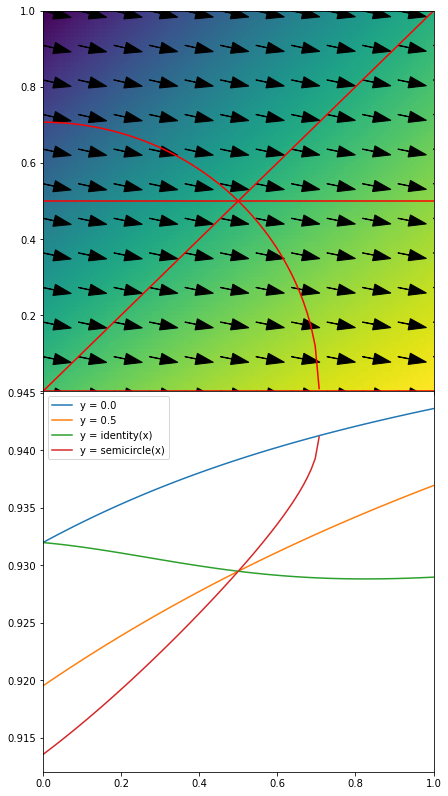

In [36]:
# def f(x): # Funcion f(x,y) = x+y,x-y
#     u = x[:,0]+x[:,1]
#     v =  x[:,0]-x[:,1]
#     return torch.vstack( (u,v) )

def f(x): # Hay que mirar tiempo
    A = torch.tensor([[0.,1.],[-1.,0.]], requires_grad=True)
    if len(x.size()) == 1:
        return A@x + torch.tensor([-0.8,+0.5])
    elif len(x.size()) == 2: # Sólo funciona para vectores o vectores de vectores (matrices)
        return (A@x.transpose(0,1)).transpose(0,1)

def error(x):
    v_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]])
    U = model(x)@v_splicer
    return torch.sum( torch.abs(U - f(x)) ) # Uso torch.sum para que sume el error de cada dimensión.


def residuales(X):
    res = 0
    for x in X:
        res += error(x)
    return res

N_in = 2
N_out = 3
model = torch.nn.Sequential(torch.nn.Linear(N_in,3), # Para exponencial
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,N_out) )

params_iniciales = copy.deepcopy(model.state_dict())

N_dominio = 500
a = 0
b = 1

xy = a + (b-a)*torch.rand(N_dominio,2) # N_dominio pares de números aleatorios entre a y b
# x1 = torch.FloatTensor(N_dominio,2).uniform_(N_dominio)
x = xy
z = model(xy)
def semicircle(x):
    return torch.sqrt(0.5-torch.pow(x,2))
def identity(x):
    return x


cortes = (0.,0.5,identity,semicircle)
plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)

print(xy.size())
print(f(xy).size())
# f(xy)
residuales(x)

Tiempo promedio:	 0.29353585249999997


<Figure size 1728x576 with 0 Axes>

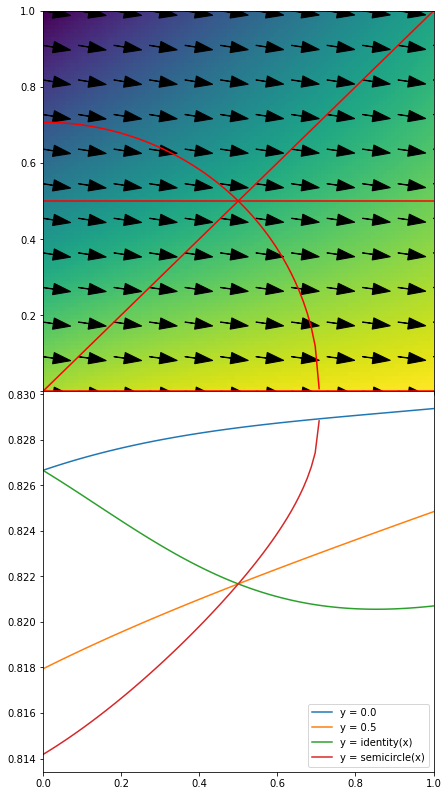

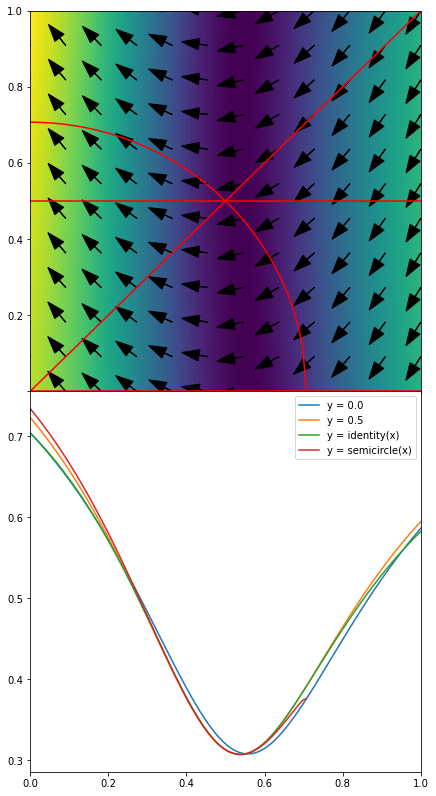

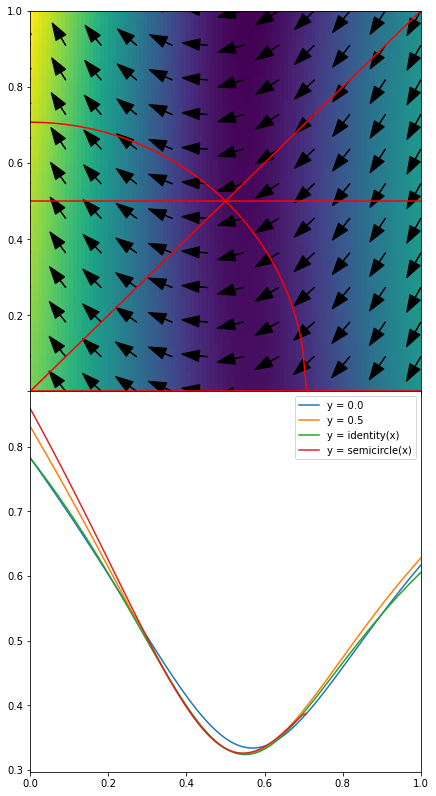

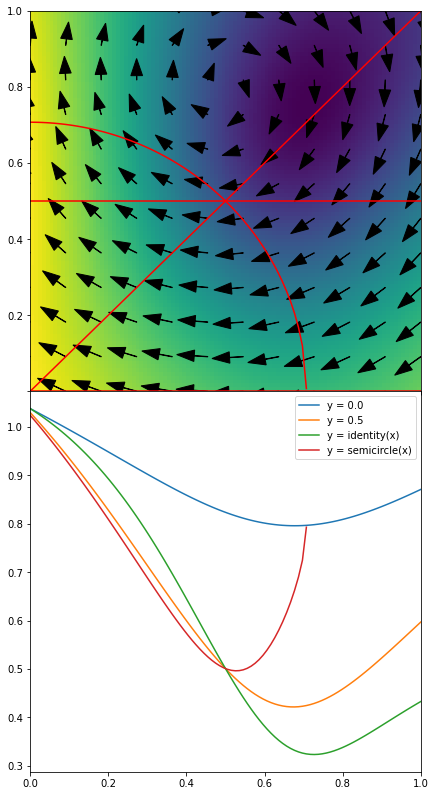

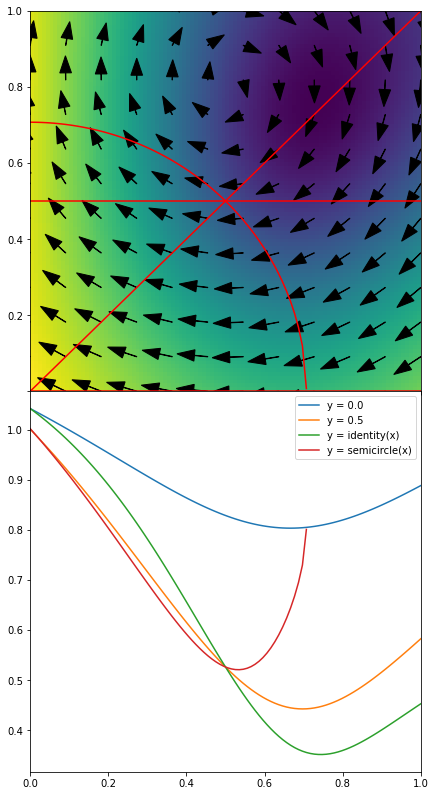

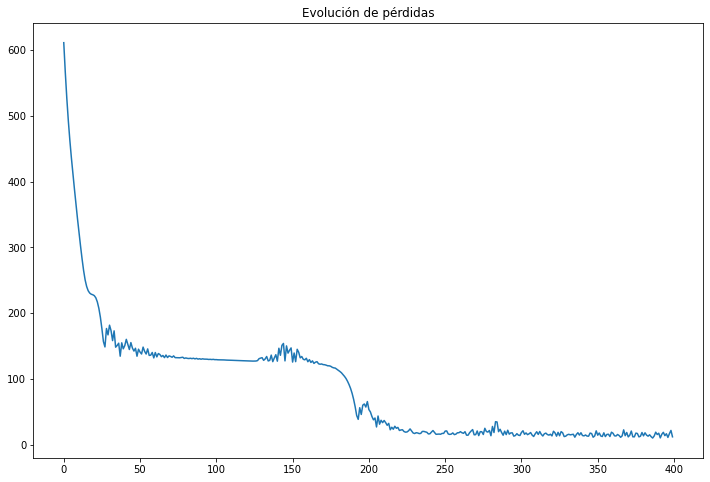

In [37]:
model.load_state_dict(params_iniciales)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=0.02)

n_epochs = 400
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_trans = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss#.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

In [38]:
def plot2D(f,rango:tuple = ((0,1),(0,1)), N_x:int = 100, N_y:int = None, N_salidas:int = 1, figsize:tuple = (7,14), plot_cut:tuple = None, axes:tuple = None) -> None: # Genera una gráfica 2D de la función f
    # plot_cut = tuple['axis',cuts]: 'axis' = 'x' or 'y', cut:list[float]
    """ Genera un gráfico 2D (como mapa de calor) de una función con entradas de dos coordenadas, sea un campo escalar f: R2 --> R, ó un campo vectorial f: R2 --> R2. Para campos escalares se grafica la
        salida como intensidad en un mapa de calor. Para funciones vectoriales se grafica la norma como un mapa de calor y las direcciones con flechas. Permite realizar 'cortes' 1D a lo largo del espacio
        bidimensional, es decir, tomar una curva unidimensional en el espacio 2D y realizar la gráfica de la función a lo largo de dicha curva. La curva se puede definir como una función de python que
        represente y(x) ó x(y). También se reciben floats para cortes verticales/horizonales. Hay soporte para múltiples cortes siempre que todos se definan para una sóla coordenada, x ó y. Las funciones
        deben estar definidas para ser compatibles con tensores de pytorch.
        
        Keyword arguments:
        f -- la función que se graficará. type(f) = function
        rango -- el espacio en R2 en el que se graficará la función, dado como una tupla ((límite_inferior_x,límite_superior_x),(límite_inferior_x,límite_superior_x))
        N_x -- resolución en x de la gráfica resultante
        N_y -- resolución en y de la gráfica resultante. Pasar None indica que se utilice la misma resolución de x 
        N_salida -- un entero 1 ó 2, que representa el número de salidas de la función
        figsize -- tamaño de la figura
        plot_cut -- tupla que contiene: un string que indica cuál variable representa la función deseada, y una tupla de funciones/floats. e.g. ('y',(torch.sqrt,3.3,torch.abs)). None si no se desea hacer
            cortes
        axes -- tupla de instancias de matplotlib.Axes.axes sobre las cuales se desee realizar las gráficas. None si se desea crear una nueva figura.
        
        Returns:
        None
    """
    
    (inf_x,sup_x),(inf_y,sup_y) = rango
    if not N_y: N_y = N_x
    if not 'device' in globals(): device='cpu' # Pone los tensores en el dispositivo escogido
    
    # Genera los axes
    if axes is None:
        fig = plt.figure(figsize=figsize)
        if plot_cut is not None:
            gs = fig.add_gridspec(2, hspace=0)
            heatmap,cutplot = gs.subplots(sharex=True, sharey=False)
        else:
            fig,heatmap = plt.subplots()
    else:
        if plot_cut is not None:
            heatmap,cutplot = axes
        else:
            heatmap = axes[0]
    
   
    # Se genera el sampleo de x,y. Se genera una matriz donde se van a almacenar los valores del mapa de calor 
    x,y = torch.linspace(inf_x,sup_x,N_x).to(device),torch.linspace(inf_y,sup_y,N_y).to(device)
    resultado = np.zeros((len(x),len(y)))
    
    # Se llena la matriz
    if N_salidas==1: # Si la función es un campo escalar (N_salidas=1) se llena la matriz con las salidas de la función
        for i in range(len(y)):
            for j in range(len(x)):
                z = f(torch.tensor([x[j],y[i]]).to(device))
                resultado[i,j] = z
    
    elif N_salidas==2:  # Si la función es un campo vectorial (N_salidas=2) se llena la matriz con las salidas de la función
        res_x = (rango[0][1] - rango[0][0])/N_x
        res_y = (rango[1][1] - rango[1][0])/N_y
        for i in range(len(y)):
            for j in range(len(x)):
                z = f(torch.tensor([x[j],y[i]]).to(device)) # Guardar z en una lista y usarla para generar el diagrama de flechas
                norm = torch.sqrt(torch.sum(torch.pow(z[:2],2))) ### Cambié para que sólo sea velocidad
                resultado[i,j] = norm
                
                if i%int(N_x/10 - 1)==0 and j%int(N_y/10 - 1)==0:
                    L0 = detach(norm)
#                     x_length = max(min(detach(z[0]),1.,key=abs),0.2,key=abs)/detach(norm)*res_x*5 #*res_x*5
#                     y_length = max(min(detach(z[1]),1.,key=abs),0.2,key=abs)/detach(norm)*res_y*5
#                     x_length = detach(z[0])/detach(norm)*res_x*5
#                     y_length = detach(z[1])/detach(norm)*res_y*5
                    x_length = detach(z[0])*(1.2*np.tanh(0.5*L0)+0.3)/L0*res_x*5
                    y_length = detach(z[1])*(1.2*np.tanh(0.5*L0)+0.3)/L0*res_y*5
                    head_width = 0.015*(np.mean([sup_x-inf_x,sup_y-inf_y]))
                    heatmap.arrow(detach(x[j]),detach(y[i]),x_length,y_length,head_width=head_width,facecolor='black')
                
     # Genera el mapa de calor
    heatmap.imshow(resultado,origin='lower',extent=[inf_x,sup_x,inf_y,sup_y])
    heatmap.set_xlim(inf_x,sup_x)
    heatmap.set_ylim(inf_y,sup_y)
    heatmap.label_outer()
    
    # Genera el gráfico de cortes, y coloca las curvas en el mapa de calor
    if plot_cut is not None:
        for cut in plot_cut[1]:
            N = N_x if plot_cut[0] == 'y' else N_y
            abscissa = torch.linspace(inf_x,sup_x,N).reshape(N,1)
            if type(cut) == float:
                ordinate = cut*torch.ones(N).reshape(N,1)
                label = plot_cut[0]+' = {:.1f}'.format(cut)
            elif callable(cut):
                ordinate = cut(abscissa)
                label = plot_cut[0]+' = '+cut.__name__+ ( '(x)' if plot_cut[0] == 'y' else '(y)')
            x,y = (abscissa,ordinate) if plot_cut[0] == 'y' else (ordinate,abscissa) 
            xy = torch.hstack((x,y))
            z = f(xy) if N_salidas == 1 else torch.sqrt(torch.sum( torch.pow(f(xy),2), axis=1 ))
            cutplot.plot(detach(x),detach(z),label=label)
            heatmap.plot(x,y,color='red')
        cutplot.label_outer()
        cutplot.yaxis.get_major_ticks()[-1].label1.set_visible(False)
        cutplot.legend()
        heatmap.yaxis.get_major_ticks()[0].label1.set_visible(False)
        
    heatmap.set_aspect('auto')
    

def plot2D_error(f,rango:tuple = ((0,1),(0,1)), N_x:int = 100, N_y:int = None, figsize:tuple = (7,14), plot_cut:tuple = None, axes:tuple = None) -> None: # Genera una gráfica 2D del error de la función f
    # plot_cut = tuple['axis',cuts]: 'axis' = 'x' or 'y', cut:list[float]
    """ Genera un gráfico 2D (como mapa de calor) del error de una función con entradas de dos coordenadas, sea un campo escalar f: R2 --> R, ó un campo vectorial f: R2 --> R2. Permite realizar 'cortes'
        1D a lo largo del espacio bidimensional, es decir, tomar una curva unidimensional en el espacio 2D y realizar la gráfica de la función a lo largo de dicha curva. La curva se puede definir como
        una función de python que represente y(x) ó x(y). También se reciben floats para cortes verticales/horizonales. Hay soporte para múltiples cortes siempre que todos se definan para una sola
        coordenada, x ó y. Las funciones deben estar definidas para ser compatibles con tensores de pytorch.
        
        Keyword arguments:
        f -- la función cuyo error se graficará. type(f) = function
        rango -- el espacio en R2 en el que se graficará la función, dado como una tupla ((límite_inferior_x,límite_superior_x),(límite_inferior_x,límite_superior_x))
        N_x -- resolución en x de la gráfica resultante
        N_y -- resolución en y de la gráfica resultante. Pasar None indica que se utilice la misma resolución de x
        figsize -- tamaño de la figura
        plot_cut -- tupla que contiene: un string que indica cuál variable representa la función deseada, y una tupla de funciones/floats. e.g. ('y',(torch.sqrt,3.3,torch.abs)). None si no se desea hacer
            cortes
        axes -- tupla de instancias de matplotlib.Axes.axes sobre las cuales se desee realizar las gráficas. None si se desea crear una nueva figura.
        
        Returns:
        None
    """
    
    (inf_x,sup_x),(inf_y,sup_y) = rango
    if not N_y: N_y = N_x
    if not 'device' in globals(): device='cpu' # Pone los tensores en el dispositivo escogido
    
    # Genera los axes
    if axes is None:
        fig = plt.figure(figsize=figsize)
        if plot_cut is not None:
            gs = fig.add_gridspec(2, hspace=0)
            heatmap,cutplot = gs.subplots(sharex=True, sharey=False)
        else:
            fig,heatmap = plt.subplots()
    else:
        if plot_cut is not None:
            heatmap,cutplot = axes
        else:
            heatmap = axes[0]
    
   
    # Se genera el sampleo de x,y. Se genera una matriz donde se van a almacenar los valores del mapa de calor 
    x,y = torch.linspace(inf_x,sup_x,N_x).to(device),torch.linspace(inf_y,sup_y,N_y).to(device)
    resultado = np.zeros((len(x),len(y)))
    
    # Se llena la matriz
    for i in range(len(y)):
        for j in range(len(x)):
            z = error(tensor([x[j],y[i]]).reshape(1,2).to(device))
            resultado[i,j] = z

     # Genera el mapa de calor
    im = heatmap.imshow(resultado,origin='lower',extent=[inf_x,sup_x,inf_y,sup_y])
    heatmap.figure.colorbar(im)
    heatmap.set_xlim(inf_x,sup_x)
    heatmap.set_ylim(inf_y,sup_y)
    heatmap.label_outer()
    
    # Genera el gráfico de cortes, y coloca las curvas en el mapa de calor
    if plot_cut is not None:
        for cut in plot_cut[1]:
            N = N_x if plot_cut[0] == 'y' else N_y
            abscissa = torch.linspace(inf_x,sup_x,N).reshape(N,1)
            if type(cut) == float:
                ordinate = cut*torch.ones(N).reshape(N,1)
                label = plot_cut[0]+' = {:.1f}'.format(cut)
            elif callable(cut):
                ordinate = cut(abscissa)
                label = plot_cut[0]+' = '+cut.__name__+ ( '(x)' if plot_cut[0] == 'y' else '(y)')
            x,y = (abscissa,ordinate) if plot_cut[0] == 'y' else (ordinate,abscissa) 
            xy = torch.hstack((x,y))
            z = []
            for xy_i in xy:
                z.append(error(xy))
            cutplot.plot(detach(x),z,label=label)
            heatmap.plot(x,y,color='red')
        cutplot.label_outer()
        cutplot.yaxis.get_major_ticks()[-1].label1.set_visible(False)
        cutplot.legend()
        heatmap.yaxis.get_major_ticks()[0].label1.set_visible(False)
        
    heatmap.set_aspect('auto')

In [39]:
def vel_jacobian(X,f): # Este jacobiano se calcula para una base de entrada de tamaño 2 y una base de salida de tamaño 3, donde sólo se quiere sacar el jacobiano para las dos primeras salidas
    # Transposed!!: esta función retorna el jacobiano en la forma convencional, no en la forma transpuesta que usa torch
     
    basis_out = [torch.tensor([1.,0.,0.]).reshape(1,3) , torch.tensor([0.,1.,0.]).reshape(1,3)]
    
    if len(X.size()) == 1 or X.size()[0]==1:
        o = basis_out[0]
        J = grad(f(X),X,grad_outputs=o,create_graph=True)[0]
        for o in basis_out[1:]:
            g = grad(f(X),X,grad_outputs=o,create_graph=True)[0]
            J = torch.vstack([J,g])
        return J
    elif len(X.size()) == 2:
        x = X[0].reshape(1,2)
        o = basis_out[0]
        J = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
        for o in basis_out[1:]:
            g = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
            J = torch.vstack([J,g])
        Js = J.reshape(1,2,2) # Por qué ese arreglo? I dunno. Así es que lo entiende bien torch
        for x in X[1:]:
            x = x.reshape(1,2)
            o = basis_out[0]
            J = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
            for o in basis_out[1:]:
                g = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
                J = torch.vstack([J,g])
            Js = torch.vstack([Js,J.reshape(1,2,2)])
        return Js
def vel_laplacian(X,f): # Para vectores o vectores de vectores (matrices Nx2)
    
    basis_in = [torch.tensor([1.,0.]).reshape(1,2) , torch.tensor([0.,1.]).reshape(1,2)] # Base de entrada a la función
    basis_out = [torch.tensor([1.,0.,0.]).reshape(1,3) , torch.tensor([0.,1.,0.]).reshape(1,3)] # Base del subespacio del espacio de salida sobre el cual se calcula el laplaciano
    in_out_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]]) # Transformación para que el laplaciano salga con la dimensionalidad del subespacio, no del espacio de salida completo
    
    
    if len(X.size()) == 1 or X.size()[0]==1:
        ΔU = torch.zeros_like(f(X))
        for o1 in basis_out:
            g = grad(f(X),X,grad_outputs=o1,create_graph=True)[0]
            r = torch.zeros_like(g)
            for o2 in basis_in:
                gg = grad(g,X,grad_outputs=o2,create_graph=True)[0]
                r += o2*gg
            ΔU += o1*torch.sum(r)
        ΔU = ΔU@in_out_splicer
        return ΔU
    
    elif len(X.size()) == 2:
        x = X[0].reshape(1,2)
        ΔU = torch.zeros_like(f(x))
        for o1 in basis_out:
            g = grad(f(x),x,grad_outputs=o1,create_graph=True)[0]
            r = torch.zeros_like(g)
            for o2 in basis_in:
                gg = grad(g,x,grad_outputs=o2,create_graph=True)[0]
                r += o2*gg
            ΔU += o1*torch.sum(r)
        ΔU = ΔU@in_out_splicer
        for x in X[1:]:
            x = x.reshape(1,2)
            ΔUi = torch.zeros_like(f(x))
            for o1 in basis_out:
                g = grad(f(x),x,grad_outputs=o1,create_graph=True)[0]
                r = torch.zeros_like(g)
                for o2 in basis_in:
                    gg = grad(g,x,grad_outputs=o2,create_graph=True)[0]
                    r += o2*gg
                ΔUi += o1*torch.sum(r)
            ΔUi = ΔUi@in_out_splicer
            ΔU = torch.vstack([ΔU,ΔUi])
    return ΔU

def pressure_gradient(X,f):
    basis_out = [torch.tensor([0.,0.,1.]).reshape(1,3)] # Base del subespacio  de la salida sobre el que se realiza gradiente
    o = basis_out[0]
    
    if len(X.size()) == 1 or X.size()[0]==1:
        grad_p = grad(f(X),X,grad_outputs=o,create_graph=True)[0]
        return grad_p
    elif len(X.size()) == 2:
        x = X[0].reshape(1,2)
        grad_p = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
        grads_p = grad_p
        for x in X[1:]:
            x = x.reshape(1,2)
            grad_p = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
            grads_p = torch.vstack([grads_p,grad_p])
        return grads_p

torch.Size([500, 2])
torch.Size([500, 2])


tensor(210116.2500, grad_fn=<AddBackward0>)

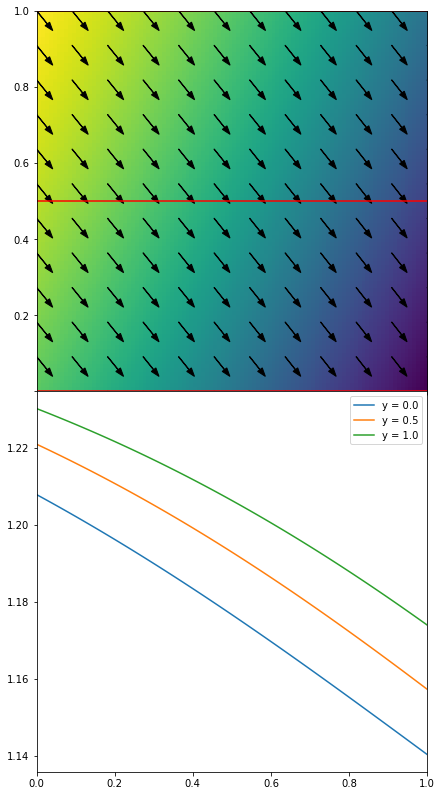

In [40]:
Re = 1
def f(x): # Hay que mirar tiempo
    A = torch.tensor([[1.,1.],[1.,-1.]], requires_grad=True)
    if len(x.size()) == 1:
        return A@x
    elif len(x.size()) == 2: # Sólo funciona para vectores o vectores de vectores (matrices)
        return (A@x.transpose(0,1)).transpose(0,1)


def error(x):
    v_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]])
    U = model(x)@v_splicer
    J = vel_jacobian(x,model)
    L = vel_laplacian(x,model)
    div_v = torch.sum(torch.diagonal(J))
    grad_p = pressure_gradient(x,model)
    
    HN = J@U.T + grad_p - 1/Re*L.T 
    e12 = torch.sum( torch.abs(HN) )
    e3 = torch.abs(div_v)
#     return 0
    return torch.abs( e12 + e3 )

def error_frontera():
    
    N_velocity = 50
    N_pressure = 20
    
    line = linspace(0,1,N=N_velocity*2)
    zeros = torch.zeros_like(line)
    ones = torch.ones_like(line)
    
    v_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]])
    p_splicer = torch.tensor([0.,0.,1.]).reshape(3,1)
    
    r_top = torch.hstack([line,ones])
    
    
    line = linspace(0,1,N=N_velocity*2)
    zeros = torch.zeros_like(line)
    ones = torch.ones_like(line)
    r_bottom,r_left,r_right = torch.hstack([line,zeros]),torch.hstack([zeros,line]),torch.hstack([ones,line]),
    r_corner = torch.tensor([0.,0.])
    
    e1 = torch.abs( model(r_bottom)@v_splicer - torch.tensor([0.,0.]) )
    e2 = torch.abs( model(r_left)@v_splicer - torch.tensor([0.,0.]) )
    e3 = torch.abs( model(r_right)@v_splicer - torch.tensor([0.,0.]) )
    e4 = torch.abs( model(r_top)@v_splicer - torch.tensor([1.,0.]) )
    e5 = N_pressure*torch.abs( model(r_corner)@p_splicer - torch.tensor(0.) )
    
    return torch.sum(e4)+torch.sum(e1+e2+e3+e3) + torch.sum(e5)


alpha = 0.6
def residuales(X):
#     print('Residuales')
    global alpha
    res = 0
    for x in X:
        x = x.reshape(1,2)
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res

N_in = 2
N_out = 3
model = torch.nn.Sequential(torch.nn.Linear(N_in,3), # Para exponencial
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,6), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(6,3), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(3,N_out) )

params_iniciales = copy.deepcopy(model.state_dict())

N_dominio = 500
a = 0
b = 1

xy = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True) # N_dominio pares de números aleatorios entre a y b
# x1 = torch.FloatTensor(N_dominio,2).uniform_(N_dominio)
x = xy
z = model(xy)


cortes = (0.,0.5,1.)
plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)

print(xy.size())
print(f(xy).size())
# f(xy)
residuales(x)

Tiempo promedio:	 0.11119942999999999


<Figure size 1728x576 with 0 Axes>

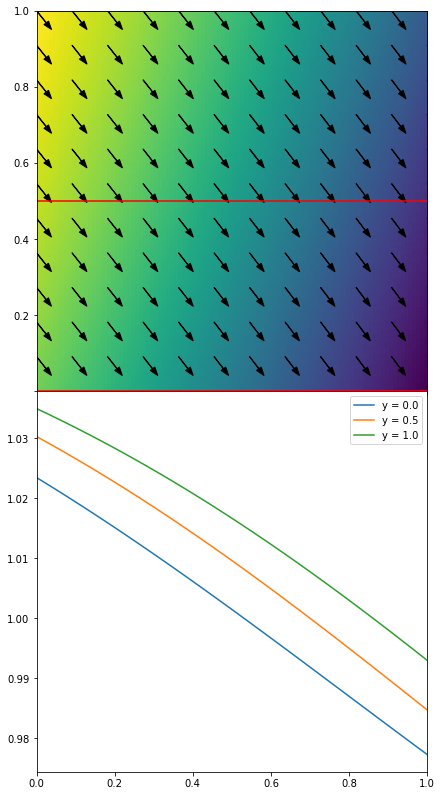

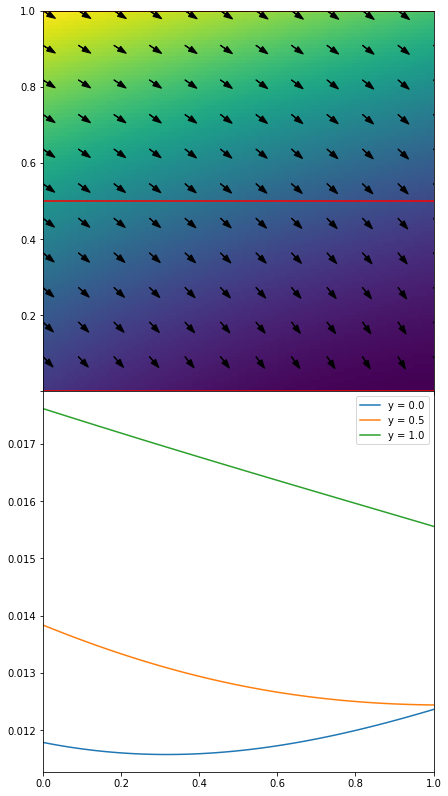

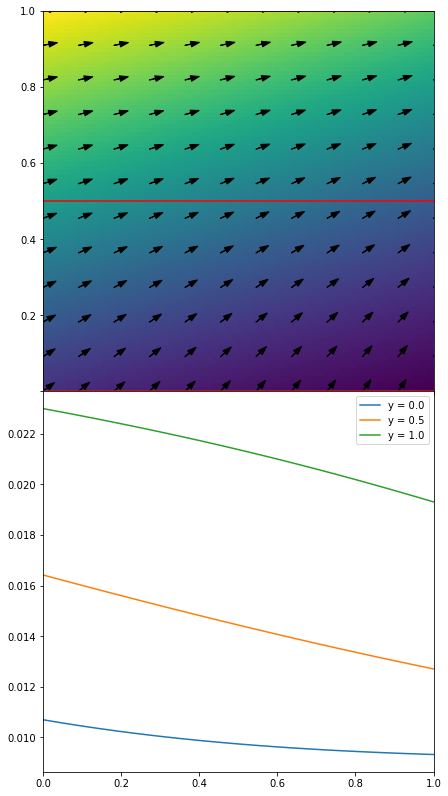

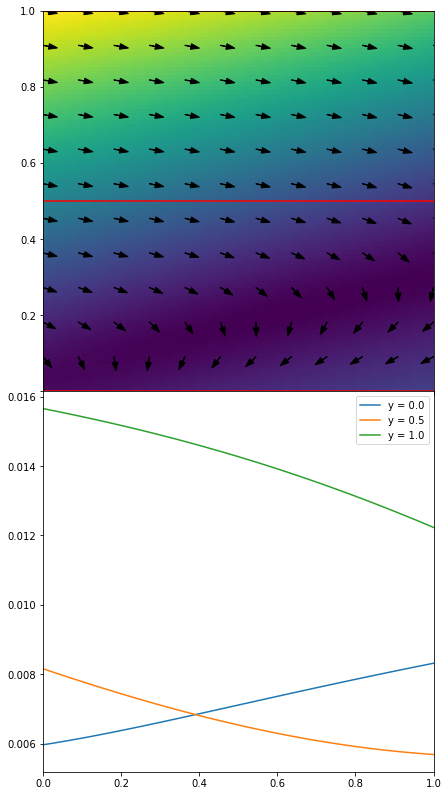

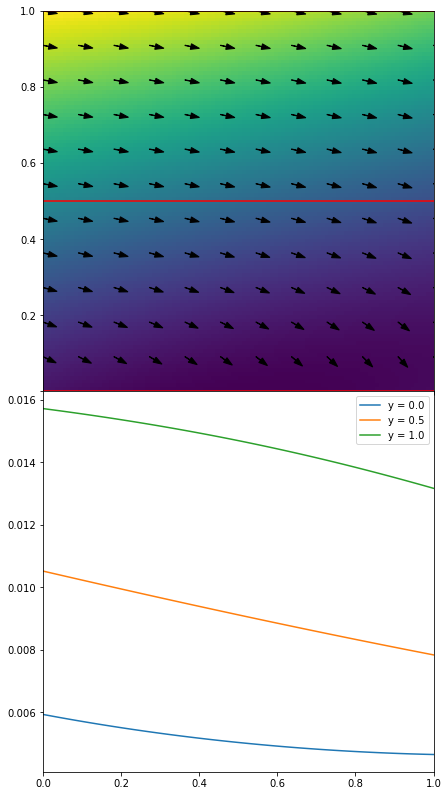

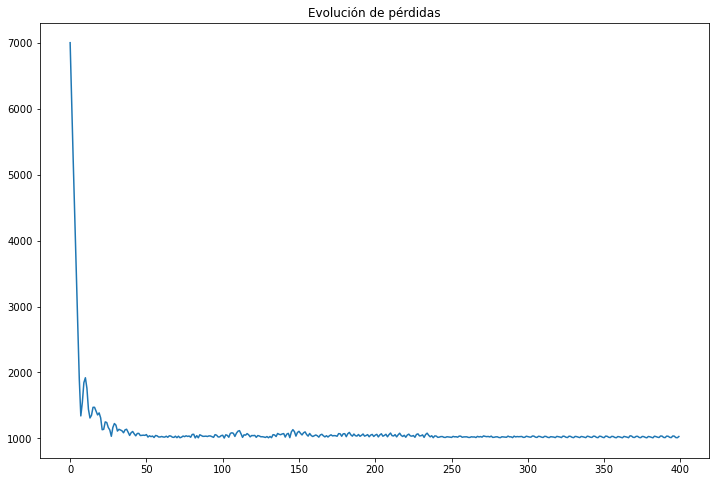

In [41]:
model.load_state_dict(params_trans)
model.load_state_dict(params_iniciales)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=0.02)

alpha = 1.
n_epochs = 400
loss_list = []
t1 = DT.datetime.now()

N_dominio = 500
N_complement = 500
N_complement = 10

dist = torch.distributions.beta.Beta(5,0.4)

def create_complement_sample(N_complement):
    sample_y = dist.sample((N_complement,))
    sample_y.requires_grad = True
    sample_x = torch.rand(N_complement,requires_grad = True)
    return torch.stack((sample_x,sample_y),dim=1)

plt.figure(figsize=(24,8))
for i in range(n_epochs):
#     x = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True)
    x = create_complement_sample(N_complement)
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss.item()) # Cambié loss por loss.item(); el cambio incrementa en 1s el tiempo del ciclo, pero parece solucionar el problema de Ram. Tal vez hay alguna manera de liberar la memoria de loss
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss#.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

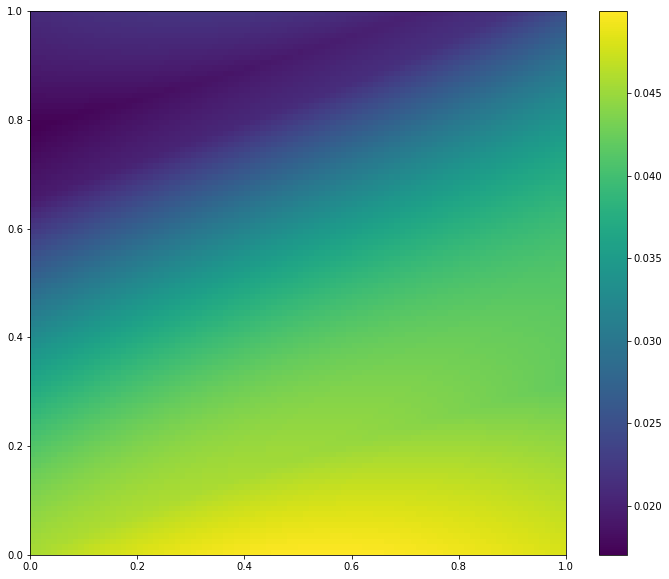

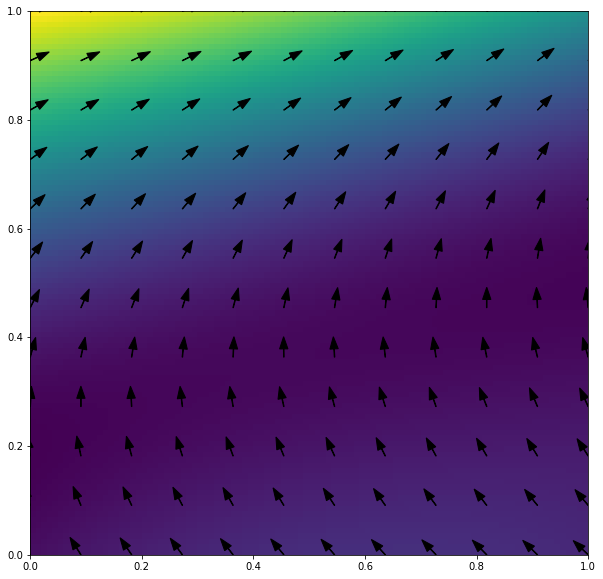

In [42]:
fig,heatmap = plt.subplots(figsize=(12,10))
plot2D_error(model,rango=((a,b),(a,b)),axes=(heatmap,))
fig2,heatmap2 = plt.subplots(figsize=(10,10))
plot2D(model,rango=((a,b),(a,b)),N_salidas=2,axes=(heatmap2,))